## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawim' #dataset-compression
TRANSFORM = 'cwt-male' #transform-group
CHANNEL = ''
NUM_BANDS = int(10)

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_cwt_1e5rawim_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawim\\cwt\\male'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


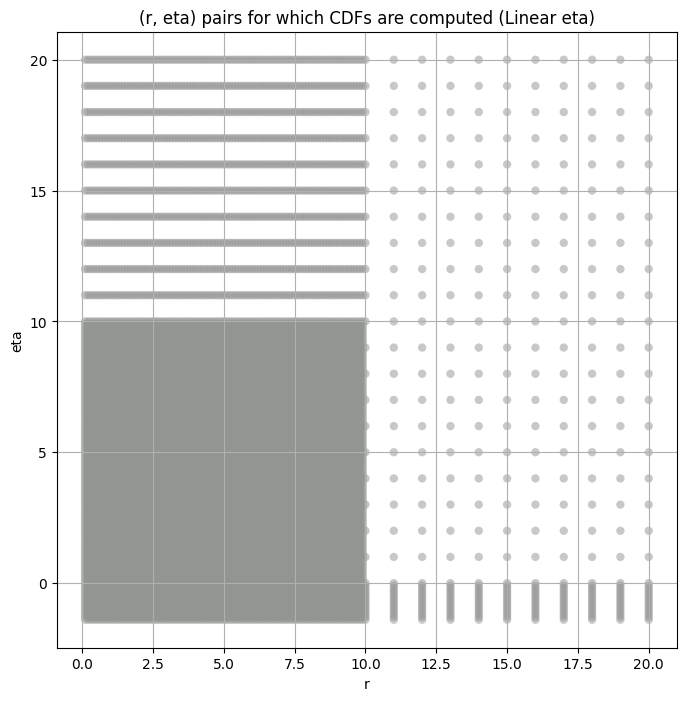

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 18


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 21


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 24


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 27


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 31


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.822466e+09  1.700348e+09  1.952399e+09    5.210897    4.492965   
5     2.076545e+09  1.956235e+09  2.200690e+09    3.248086    2.778626   
8     1.659445e+09  1.563706e+09  1.757885e+09    3.239433    2.819896   
11    1.339808e+09  1.261085e+09  1.419867e+09    3.335166    3.002649   
14    2.495633e+08  2.280835e+08  2.721146e+08    9.824538    8.402328   
18    6.059082e+07  5.541465e+07  6.623616e+07   10.046114    7.309242   
21    2.773545e+07  2.484259e+07  3.092608e+07   15.857981   11.606464   
24    1.956322e+07  1.685660e+07  2.253087e+07   29.648762   24.566576   
27    5.385740e+06  4.516624e+06  6.365170e+06   42.103700   31.579062   
31    1.729454e+05  1.348808e+05  2.302596e+05  106.234030   49.286438   

      kurt_upper  total_samples  
band                             
2       6.073390     57390260.0  
5       3.767907     57390260.0  
8       3.693572     57390260.0  
11      3.688461     57390260.0  
14     11.439768     57390260.0  
18     14.069856     57390260.0  
21     22.578720     57390260.0  
24     35.480534     57390260.0  
27     57.521360     57390260.0  
31    312.297030     57390260.0

## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                                
2     1.822466e+09   1.822466e+09    1.788661e+09    1.763091e+09   
5     2.076545e+09   2.076545e+09    2.046752e+09    2.023046e+09   
8     1.659445e+09   1.659445e+09    1.637126e+09    1.618911e+09   
11    1.339808e+09   1.339808e+09    1.325657e+09    1.313180e+09   
14    2.495633e+08   2.495633e+08    2.426564e+08    2.373676e+08   
18    6.059082e+07   6.059082e+07    5.829281e+07    5.679762e+07   
21    2.773545e+07   2.773545e+07    2.640286e+07    2.552624e+07   
24    1.956322e+07   1.956322e+07    1.844416e+07    1.759926e+07   
27    5.385740e+06   5.385740e+06    4.943811e+06    4.653038e+06   
31    1.729454e+05   1.729454e+05    1.477778e+05    1.347692e+05   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2       1.740493e+09     1.719800e+09     1.682227e+09     1.648227e+09   
5       2.001734e+09     1.981993e+09     1.945887e+09     1.913085e+09   
8       1.602657e+09     1.587658e+09     1.560192e+09     1.535155e+09   
11      1.301530e+09     1.290476e+09     1.269687e+09     1.250243e+09   
14      2.327489e+08     2.285564e+08     2.210442e+08     2.143701e+08   
18      5.557505e+07     5.451775e+07     5.272374e+07     5.121217e+07   
21      2.480816e+07     2.418771e+07     2.313745e+07     2.225929e+07   
24      1.687715e+07     1.623762e+07     1.513223e+07     1.419296e+07   
27      4.417238e+06     4.215554e+06     3.879127e+06     3.602560e+06   
31      1.249641e+05     1.170205e+05     1.045795e+05     9.501670e+04   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2        1.616849e+09     1.587534e+09     1.559893e+09     1.484820e+09  
5        1.882762e+09     1.854427e+09     1.827753e+09     1.755443e+09  
8        1.511853e+09     1.489885e+09     1.469016e+09     1.411638e+09  
11       1.231858e+09     1.214350e+09     1.197587e+09     1.150906e+09  
14       2.083090e+08     2.027303e+08     1.975479e+08     1.838226e+08  
18       4.989231e+07     4.871405e+07     4.764664e+07     4.491791e+07  
21       2.149945e+07     2.082711e+07     2.022261e+07     1.869865e+07  
24       1.337455e+07     1.264976e+07     1.200020e+07     1.038901e+07  
27       3.366970e+06     3.161655e+06     2.980184e+06     2.538865e+06  
31       8.728248e+04     8.082505e+04     7.530964e+04     6.256925e+04

####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.032941758473953475 1822465700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.032459474685464285 1788660700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.033204994279538866 1763091000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.03387609459330554 1740492800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.03449912064796967 1719800200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.03564416026847261 1682226800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.03670223839835751 1648227200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.03641790116550081 1616849300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.035703232396742446 1587534000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.03602589254079615 1559892600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.03858819324947016 1484819800.0
Number of samples: 100000, Without approximation : 57390260.0


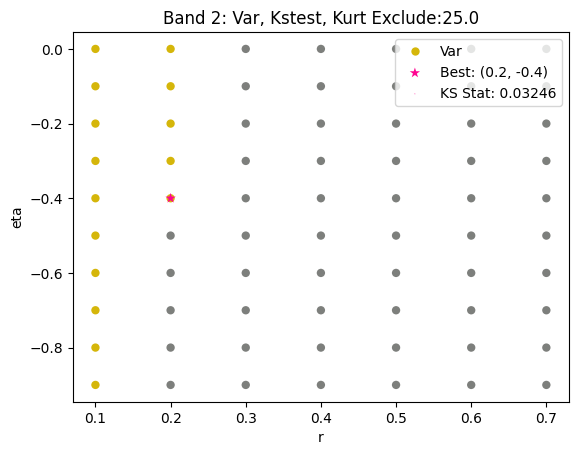

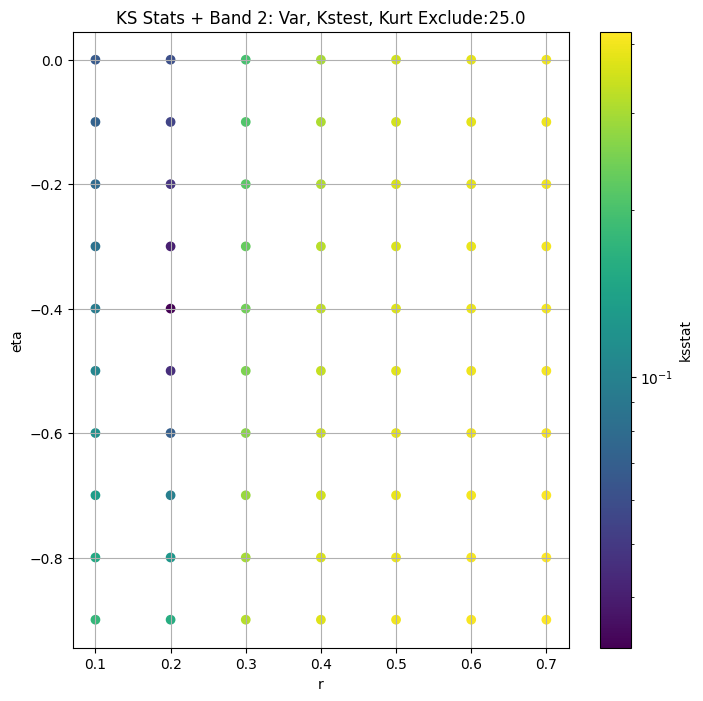

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.02565423098877062 2076545300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.026484816123983235 2046751700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.027000651188608338 2023046000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.026697697876248372 2001734100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.026787899775015278 1981993200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.027827110737063232 1945887100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.027547160610592814 1913085400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.028685756730106093 1882762000.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.028234837155242054 1854426800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.029221381968737345 1827753500.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.029896112703448163 1755443500.0
Number of samples: 100000, Without approximation : 57390260.0


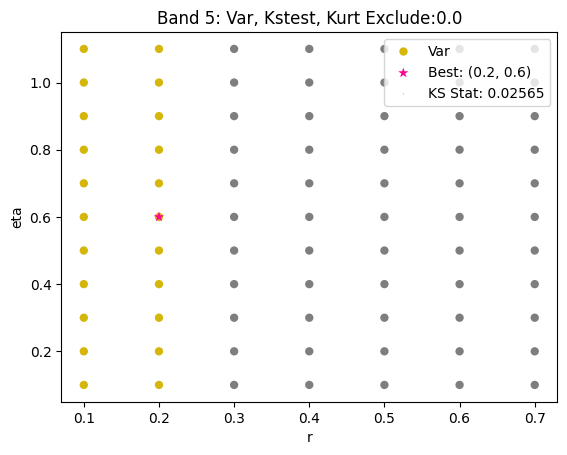

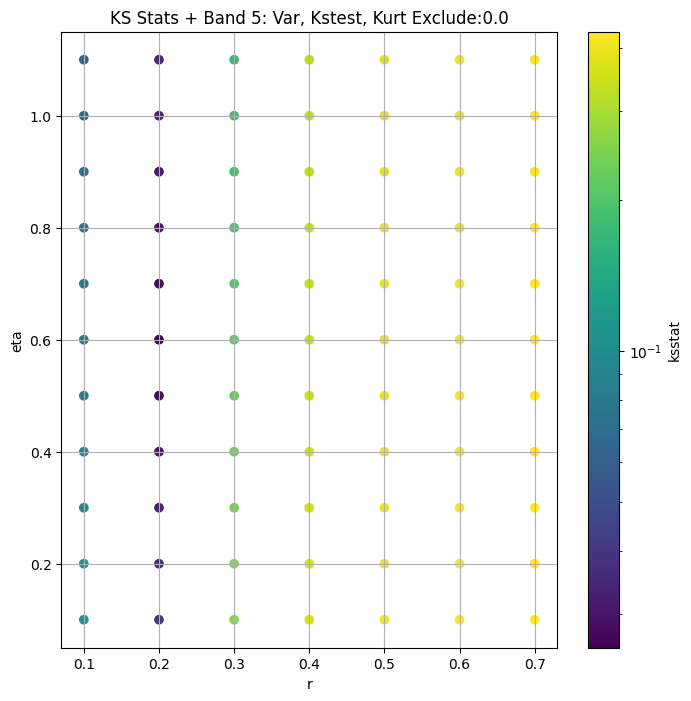

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.023237767127465947 1659444600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.024089809261138684 1637126300.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.024634781334938682 1618910700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.024382492501323183 1602656800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0241500628625253 1587658400.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.02537445531638971 1560191900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.025182615510441597 1535154600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.025699174700847316 1511852800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.026202636887361686 1489884700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.026028044500063685 1469015900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.027321777365629324 1411637900.0
Number of samples: 100000, Without approximation : 57390260.0


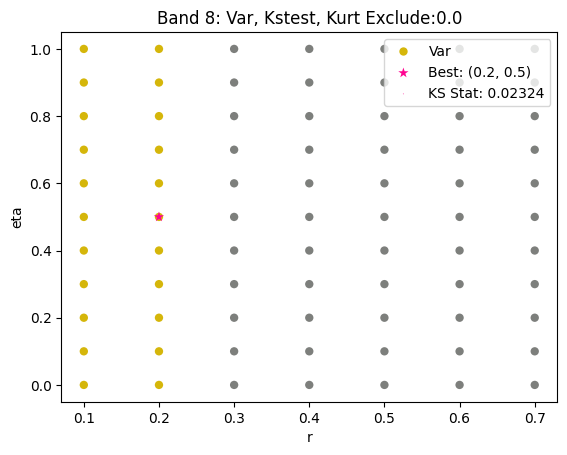

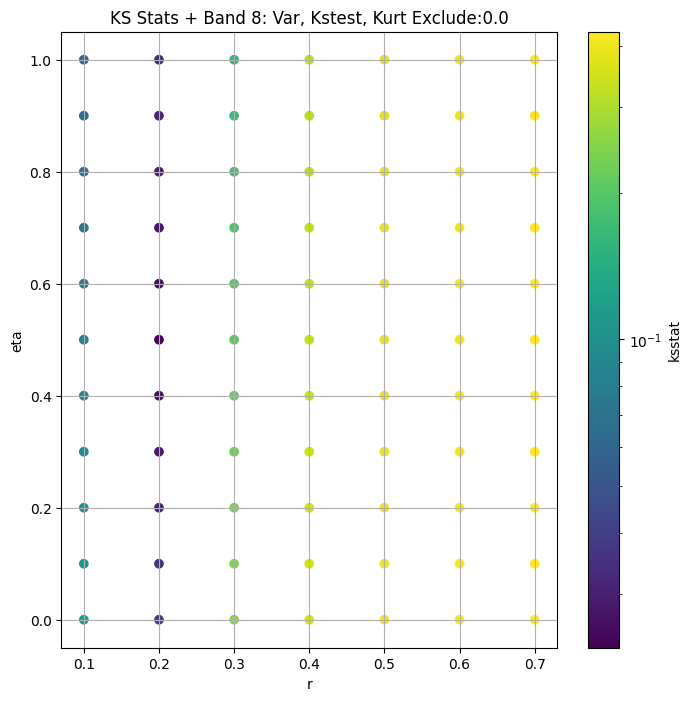

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.03226484633845367 1339807900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.0328429287793975 1325656600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.03335618556158912 1313179600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.0338402851416118 1301529600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.03411745216463913 1290475600.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.03354169175017235 1269686900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.03326538332019345 1250243100.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.03406797463320044 1231857800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.03485230501701486 1214349700.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.035610805678466195 1197586800.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.03542431912916902 1150905600.0
Number of samples: 100000, Without approximation : 57390260.0


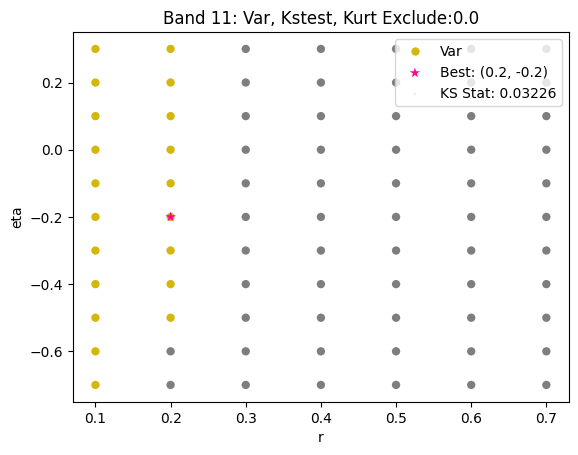

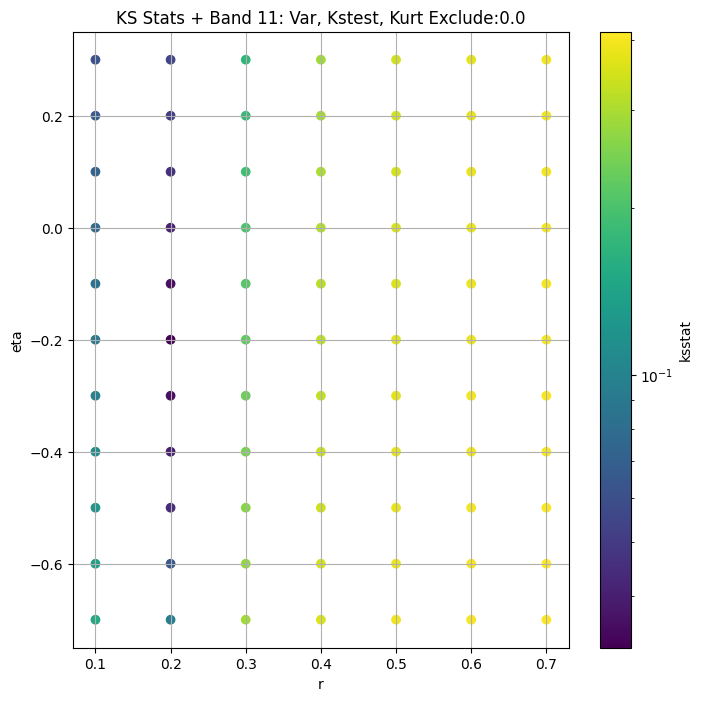

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.020031075384698935 249563260.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.021421459865926737 242656370.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.02251285812483568 237367630.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.023492584140333617 232748900.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.02380264358092321 228556370.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.022668741540204262 221044200.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.022741901862711744 214370110.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.02415531540588725 208309040.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.025498725214139095 202730320.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.026780826230721894 197547890.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.026486374920849917 183822580.0
Number of samples: 100000, Without approximation : 57390260.0


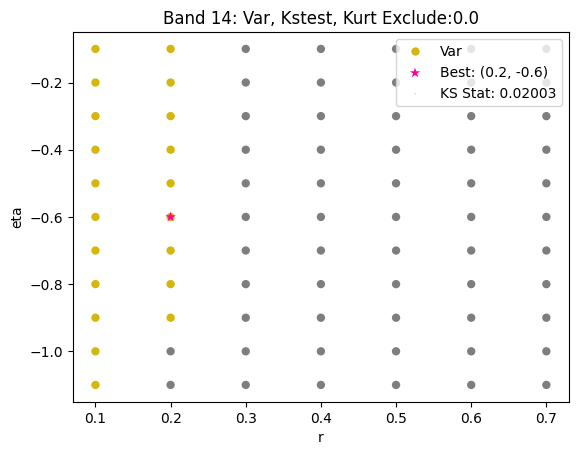

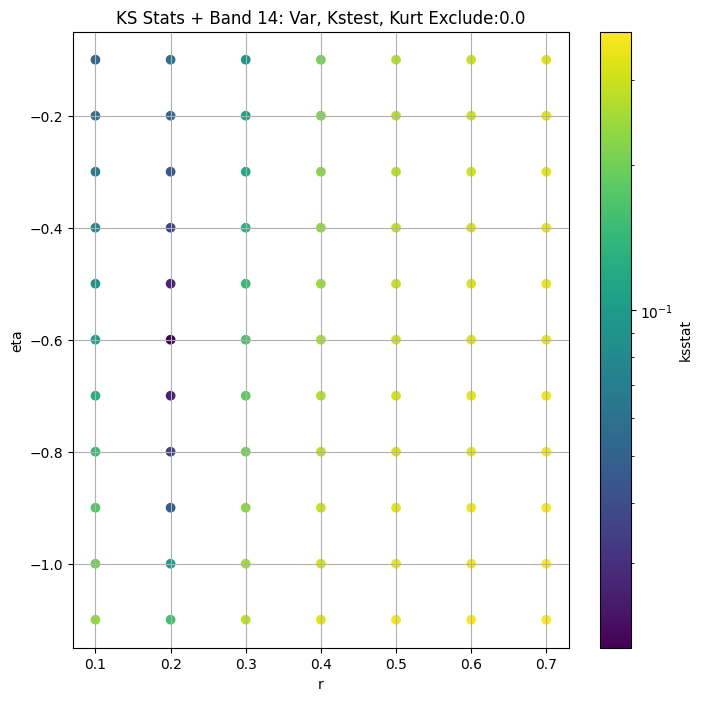

####
Band  18


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 0 0.018708496746823844 60590816.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 25 0.017852106917663257 58292812.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 50 0.019054283349884765 56797616.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 75 0.02028408797943554 55575052.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 100 0.0204264266755535 54517748.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 150 0.02027611740090085 52723736.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 200 0.021896633003314334 51212170.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 250 0.022104209091431293 49892310.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 300 0.022208568812654178 48714052.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 350 0.023433145692043605 47646640.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
18 500 0.024604789830017487 44917908.0
Number of samples: 100000, Without approximation : 57390260.0


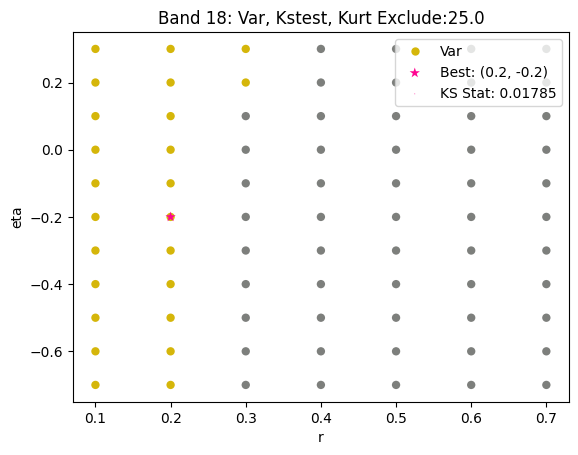

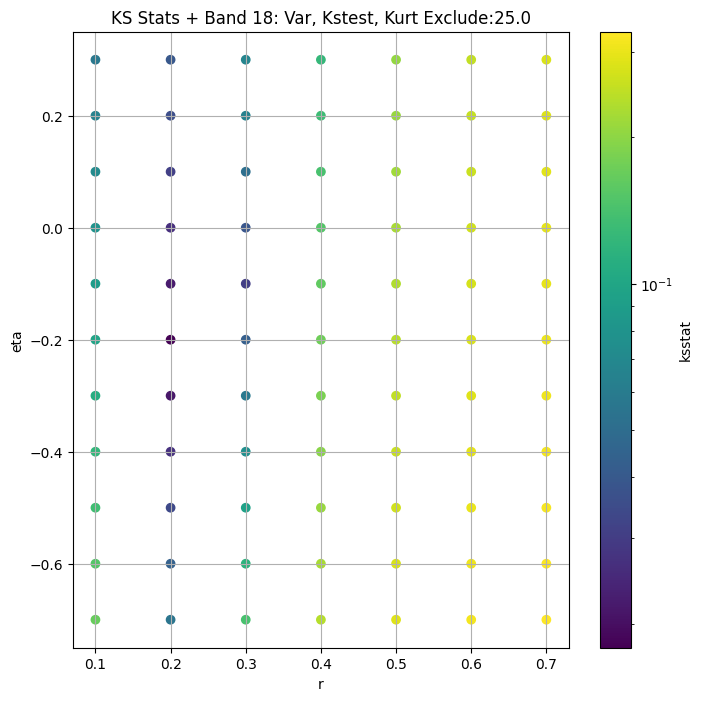

####
Band  21


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 0 0.0159401756081054 27735454.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 25 0.018667692145506898 26402860.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 50 0.01779766923349224 25526242.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 75 0.017006319529731417 24808158.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 100 0.017435541155764483 24187706.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 150 0.01978670400407806 23137452.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 200 0.021562844126568614 22259292.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 250 0.020534530246307137 21499448.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 300 0.020878924230925633 20827108.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 350 0.022405857553324582 20222614.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
21 500 0.02310808352587268 18698648.0
Number of samples: 100000, Without approximation : 57390260.0


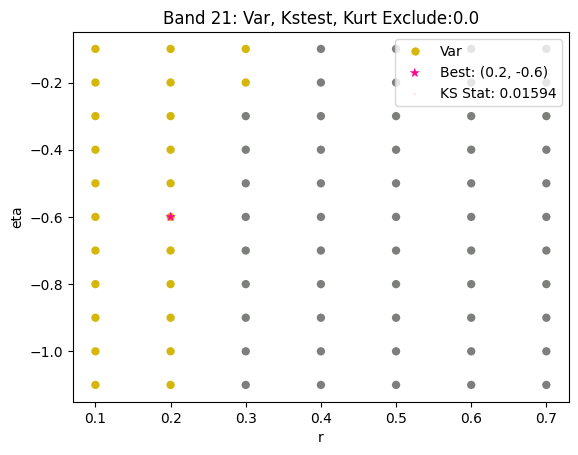

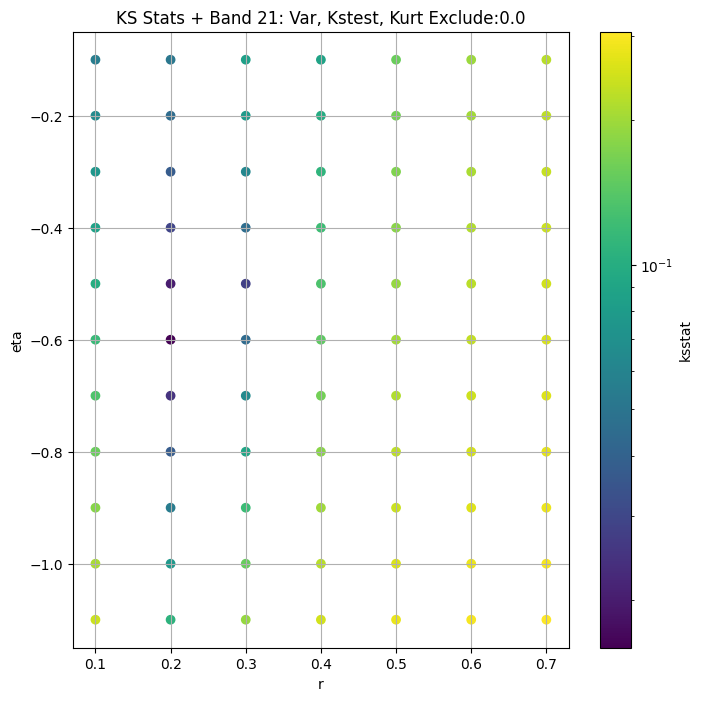

####
Band  24


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 0 0.010801683771463955 19563218.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 25 0.00998482710351678 18444156.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 50 0.007653493600909722 17599260.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 75 0.006659852643569792 16877148.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 100 0.007431045525420454 16237624.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 150 0.008975941056018732 15132227.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 200 0.010485244984599205 14192962.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 250 0.011993955338020633 13374549.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 300 0.01354076749451201 12649759.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 350 0.014848793675961258 12000201.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
24 500 0.014594016706504287 10389008.0
Number of samples: 100000, Without approximation : 57390260.0


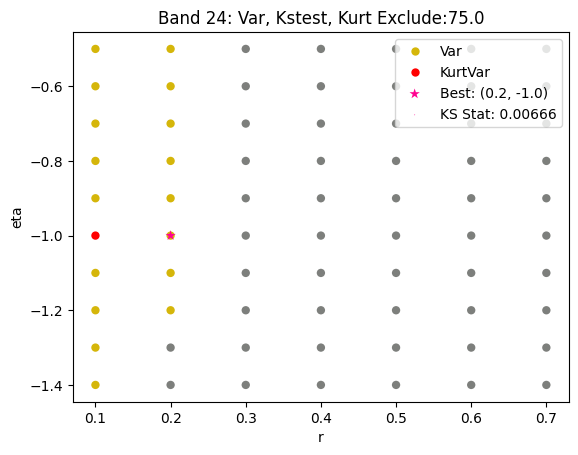

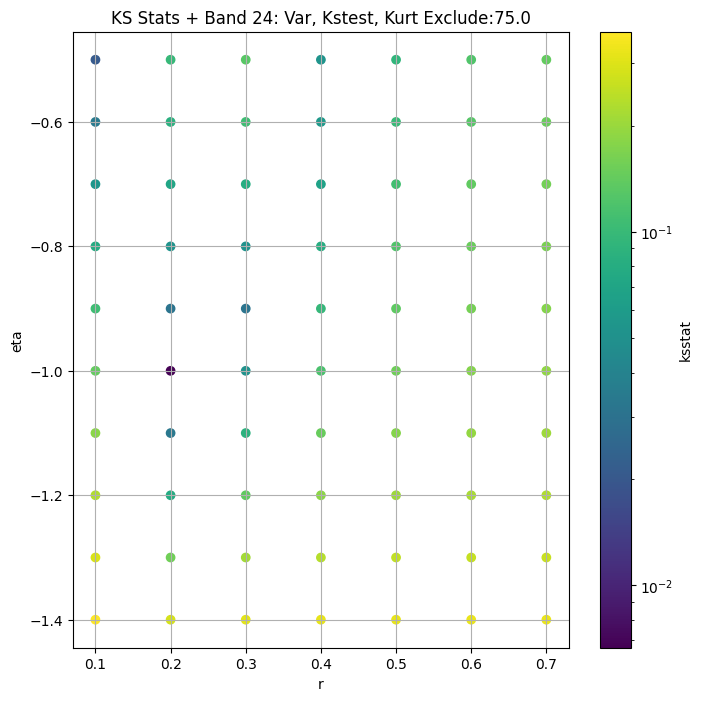

####
Band  27


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 0 0.015910284603199876 5385740.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 25 0.01677359068373463 4943811.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 50 0.016587896781975475 4653037.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 75 0.014618755937321315 4417238.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 100 0.014455937130696594 4215553.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 150 0.014313270215675411 3879127.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 200 0.01419265345375409 3602560.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 250 0.014083815817566125 3366969.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 300 0.013984120130274502 3161654.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 350 0.013893920355989353 2980184.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
27 500 0.014011672720200707 2538865.2
Number of samples: 100000, Without approximation : 57390260.0


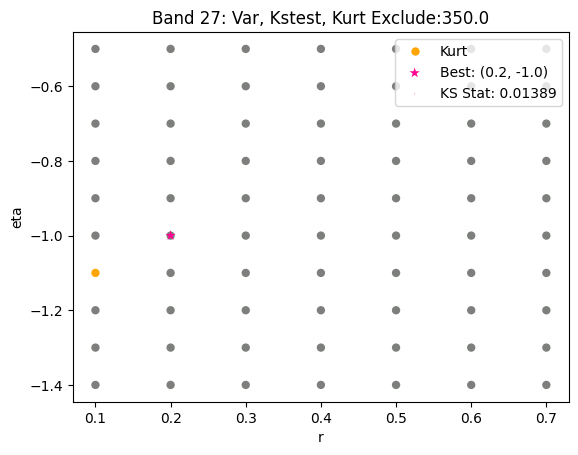

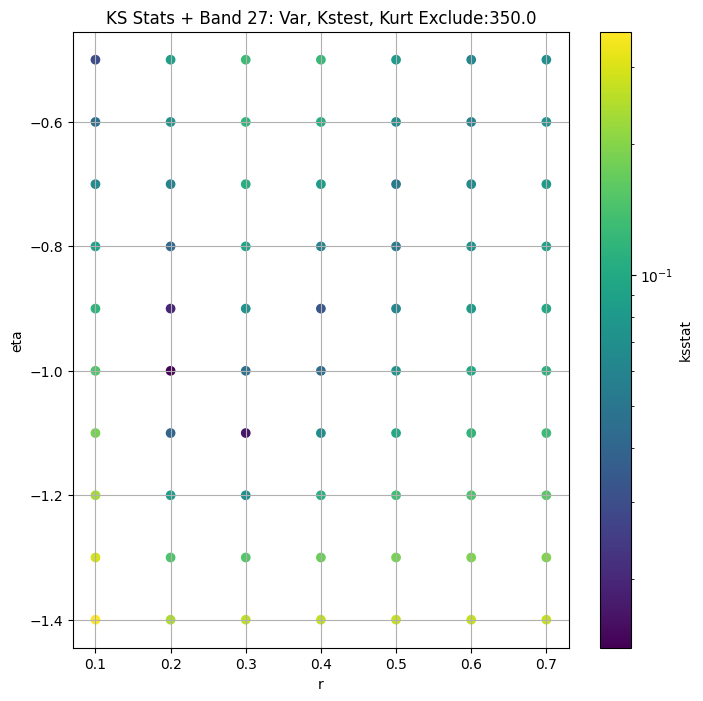

####
Band  31


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 0 0.036155984430743304 172945.42


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 25 0.03603373049794367 147777.84


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 50 0.035928247383944956 134769.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 75 0.035839752481028886 124964.055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 100 0.03576427235267565 117020.46


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 150 0.0360614097565386 104579.484


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 200 0.035951902751869325 95016.695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 250 0.03585238124789086 87282.484


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 300 0.03576758437740496 80825.055


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 350 0.03568969079496098 75309.64


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
31 500 0.036155984430743304 62569.246
Number of samples: 100000, Without approximation : 57390260.0


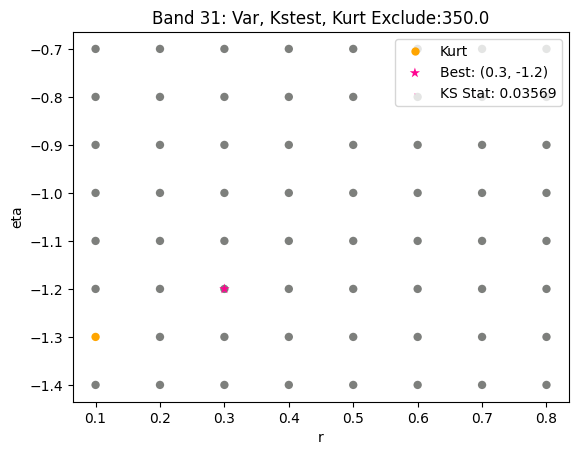

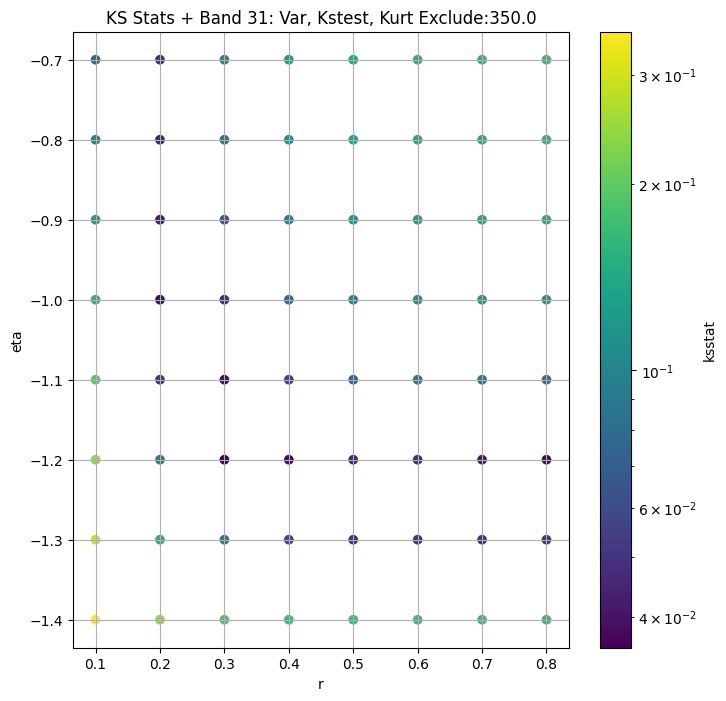

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.822466e+09  1.700348e+09  1.952399e+09    5.210897    4.492965   
5     2.076545e+09  1.956235e+09  2.200690e+09    3.248086    2.778626   
8     1.659445e+09  1.563706e+09  1.757885e+09    3.239433    2.819896   
11    1.339808e+09  1.261085e+09  1.419867e+09    3.335166    3.002649   
14    2.495633e+08  2.280835e+08  2.721146e+08    9.824538    8.402328   
18    6.059082e+07  5.541465e+07  6.623616e+07   10.046114    7.309242   
21    2.773545e+07  2.484259e+07  3.092608e+07   15.857981   11.606464   
24    1.956322e+07  1.685660e+07  2.253087e+07   29.648762   24.566576   
27    5.385740e+06  4.516624e+06  6.365170e+06   42.103700   31.579062   
31    1.729454e+05  1.348808e+05  2.302596e+05  106.234030   49.286438   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       6.073390     57390260.0             0.032459        0.2         -0.4   
5       3.767907     57390260.0             0.025654        0.2          0.6   
8       3.693572     57390260.0             0.023238        0.2          0.5   
11      3.688461     57390260.0             0.032265        0.2         -0.2   
14     11.439768     57390260.0             0.020031        0.2         -0.6   
18     14.069856     57390260.0             0.017852        0.2         -0.2   
21     22.578720     57390260.0             0.015940        0.2         -0.6   
24     35.480534     57390260.0             0.006660        0.2         -1.0   
27     57.521360     57390260.0             0.013894        0.2         -1.0   
31    312.297030     57390260.0             0.035690        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      82612.950489                    25.0        1.788661e+09   
5       7028.173634                     0.0        2.076545e+09   
8       6907.445088                     0.0        1.659445e+09   
11     32414.257290                     0.0        1.339808e+09   
14     24333.910593                     0.0        2.495633e+08   
18      1410.290420                    25.0        5.829281e+07   
21      2704.372619                     0.0        2.773545e+07   
24     11989.537929                    75.0        1.687715e+07   
27      2117.124831                   350.0        2.980184e+06   
31      8132.326628                   350.0        7.530964e+04   

      kstest_stat_cutoff_0.05  
band                           
2                    0.000179  
5                    0.000179  
8                    0.000179  
11                   0.000179  
14                   0.000179  
18                   0.000179  
21                   0.000179  
24                   0.000179  
27                   0.000179  
31                   0.000179

In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 100 = 125, ksstat: 0.03364316551118651, var: 1700473344.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 75 = 100, ksstat: 0.03336375237810216, var: 1719800192.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 50 = 75, ksstat: 0.033113606131463955, var: 1740492800.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 25 = 50, ksstat: 0.032821750474511524, var: 1763090944.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + 0 = 25, ksstat: 0.032459474685464285, var: 1788660736.0


  0%|          | 0/1188 [00:00<?, ?it/s]

Finding Minimum after computing 1188 CDFs
band 2, 25.0 + -25 = 0, ksstat: 0.03206387904572944, var: 1822465664.0
Number of samples: 100000, Without approximation : 57390260.0


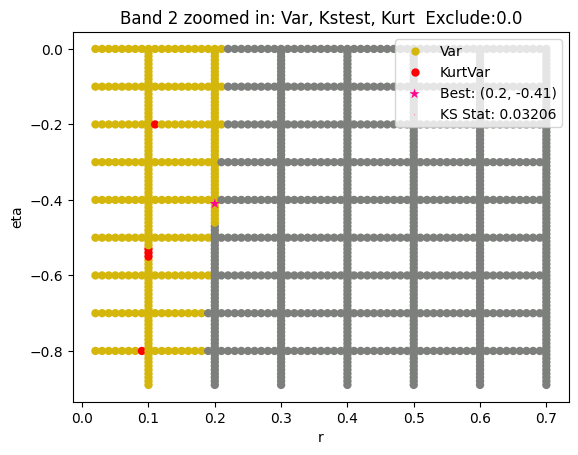

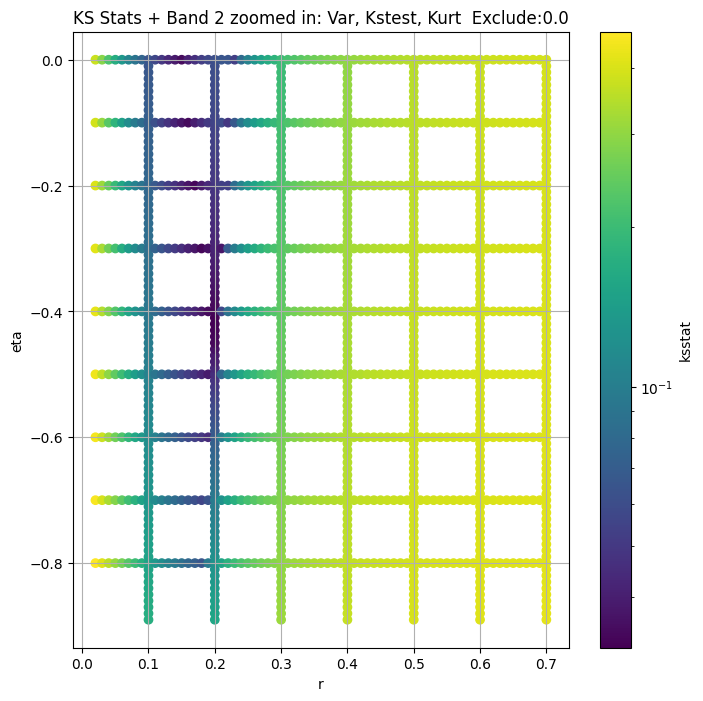

Band 5


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 100 = 100, ksstat: 0.026063046598346573, var: 1981993216.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 75 = 75, ksstat: 0.026190097462190698, var: 2001734144.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 50 = 50, ksstat: 0.026491076417216708, var: 2023046016.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 25 = 25, ksstat: 0.02596380581299315, var: 2046751744.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 5, 0.0 + 0 = 0, ksstat: 0.025300987815499942, var: 2076545280.0
Number of samples: 100000, Without approximation : 57390260.0


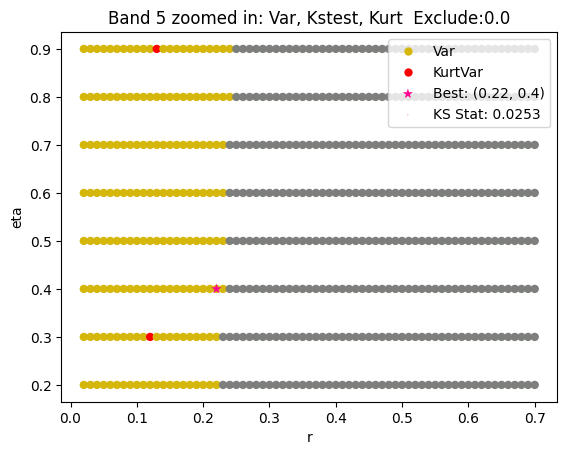

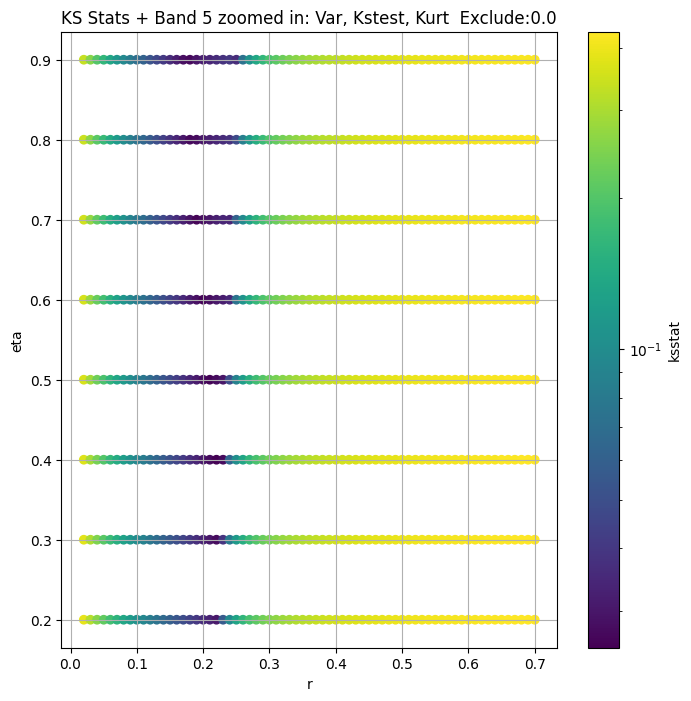

Band 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 100 = 100, ksstat: 0.023665422571440692, var: 1587658368.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 75 = 75, ksstat: 0.023568090684369047, var: 1602656768.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 50 = 50, ksstat: 0.023814387349223698, var: 1618910720.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 25 = 25, ksstat: 0.023773971895728496, var: 1637126272.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 8, 0.0 + 0 = 0, ksstat: 0.02279671604901856, var: 1659444608.0
Number of samples: 100000, Without approximation : 57390260.0


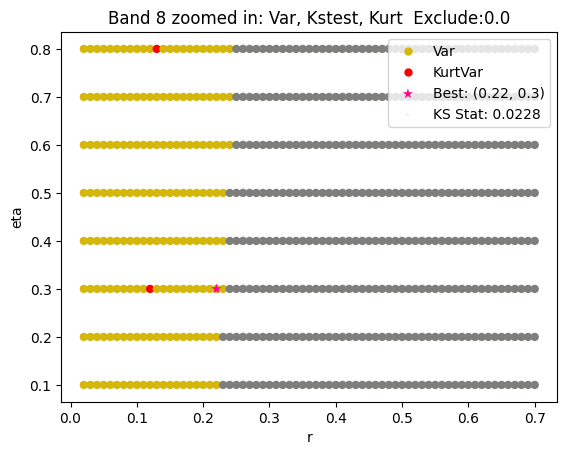

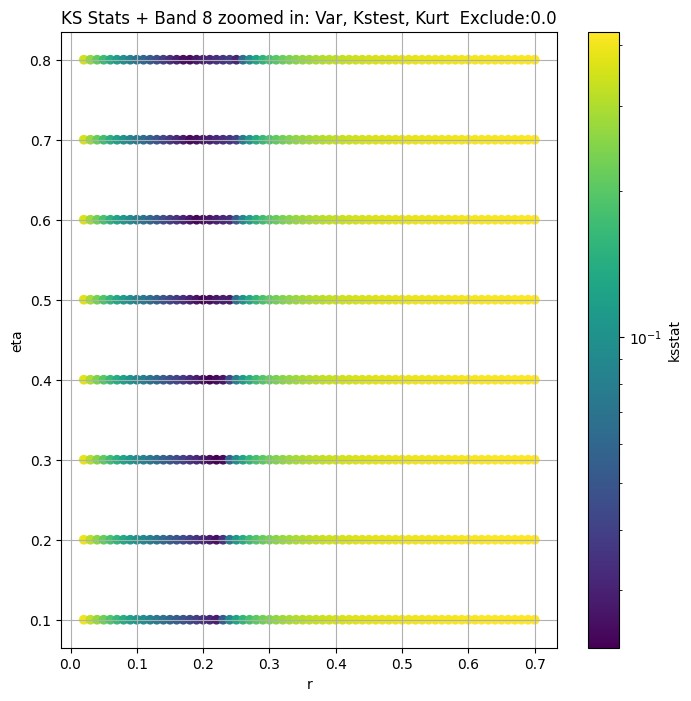

Band 11


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 100 = 100, ksstat: 0.032102602479675335, var: 1290475648.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 75 = 75, ksstat: 0.03219102823815129, var: 1301529600.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 50 = 50, ksstat: 0.031931749602519544, var: 1313179648.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 25 = 25, ksstat: 0.03168413331227116, var: 1325656576.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 11, 0.0 + 0 = 0, ksstat: 0.03147002734672577, var: 1339807872.0
Number of samples: 100000, Without approximation : 57390260.0


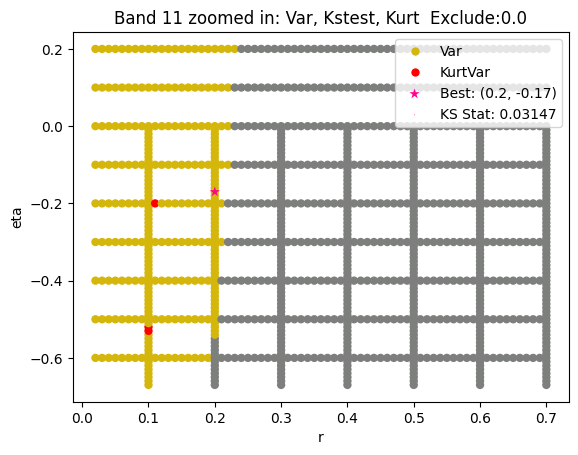

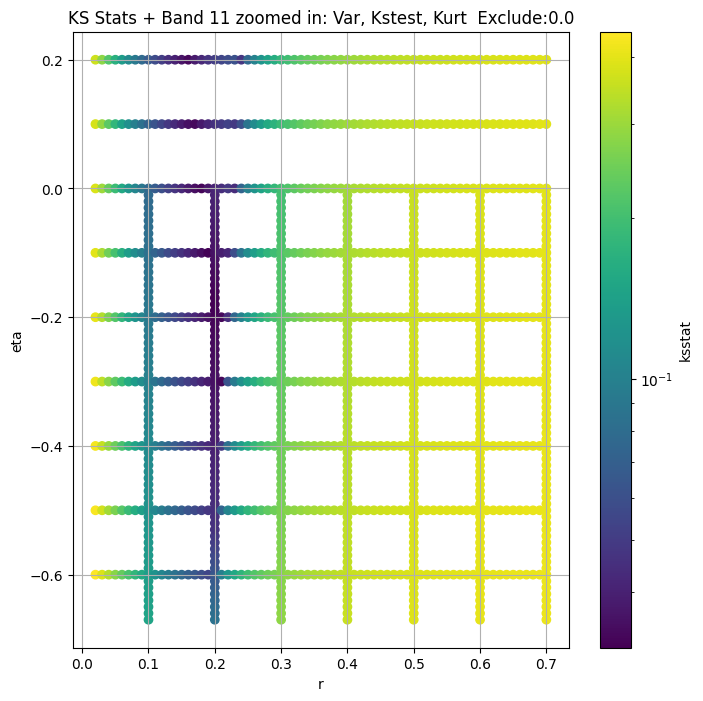

Band 14


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 100 = 100, ksstat: 0.020954003411979172, var: 228556368.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 75 = 75, ksstat: 0.02044547317060108, var: 232748896.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 50 = 50, ksstat: 0.01962803815079972, var: 237367632.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 25 = 25, ksstat: 0.019857352149932117, var: 242656368.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 14, 0.0 + 0 = 0, ksstat: 0.01897882024697317, var: 249563264.0
Number of samples: 100000, Without approximation : 57390260.0


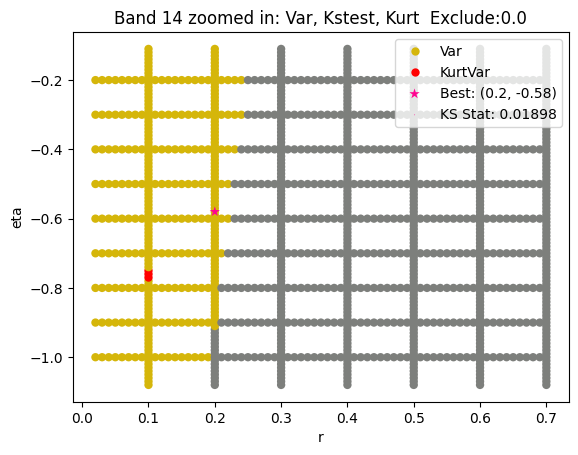

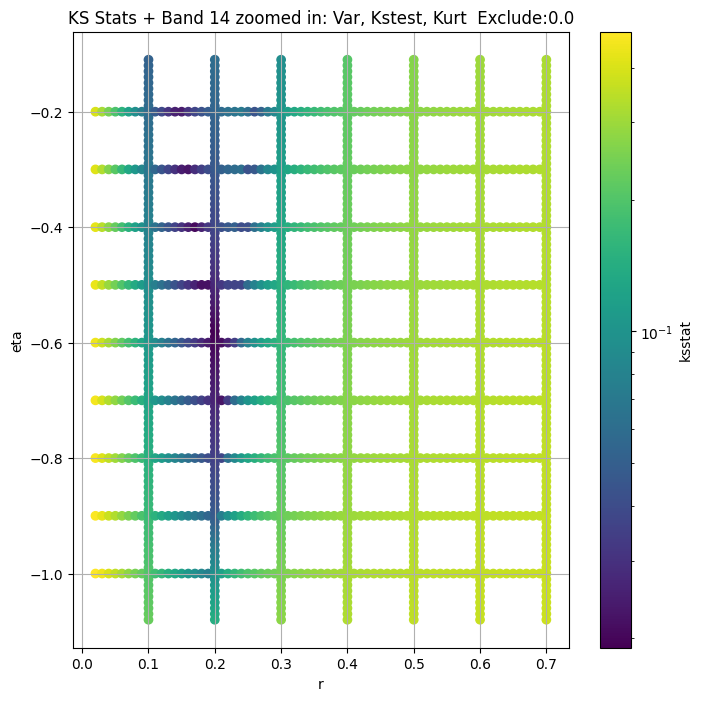

Band 18


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 100 = 125, ksstat: 0.018171255624259364, var: 53576832.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 75 = 100, ksstat: 0.01837570015405733, var: 54517748.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 50 = 75, ksstat: 0.017627651432828934, var: 55575052.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 25 = 50, ksstat: 0.01742320525810459, var: 56797616.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + 0 = 25, ksstat: 0.016607807097426056, var: 58292812.0


  0%|          | 0/1131 [00:00<?, ?it/s]

Finding Minimum after computing 1131 CDFs
band 18, 25.0 + -25 = 0, ksstat: 0.015559949888821034, var: 60590816.0
Number of samples: 100000, Without approximation : 57390260.0


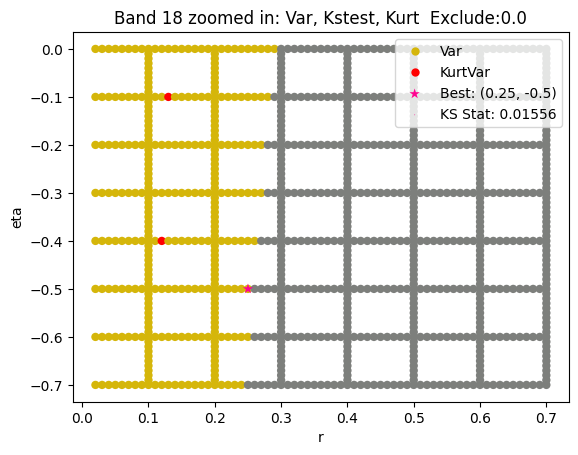

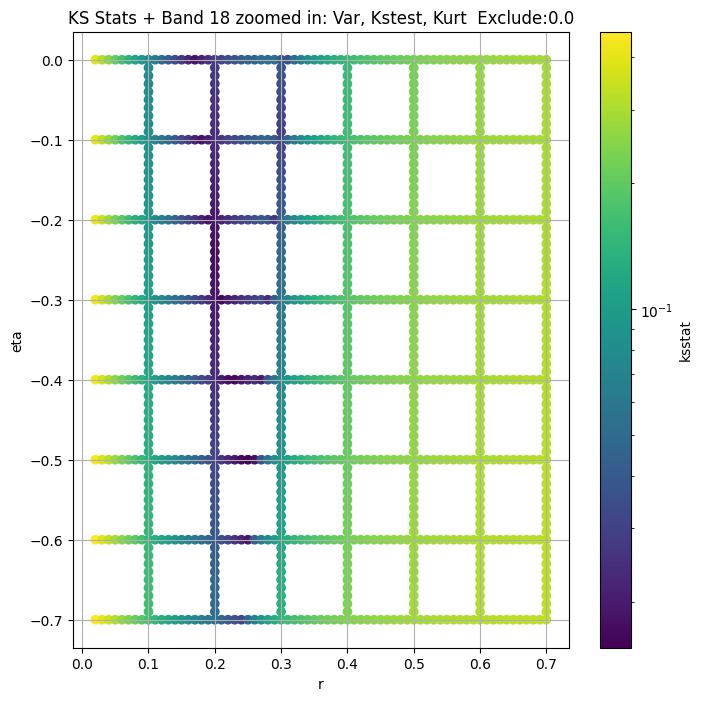

Band 21


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 100 = 100, ksstat: 0.015095931266620233, var: 24187706.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 75 = 75, ksstat: 0.015284351623279027, var: 24808158.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 50 = 50, ksstat: 0.013799089449790802, var: 25526242.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 25 = 25, ksstat: 0.014436020176213704, var: 26402860.0


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 21, 0.0 + 0 = 0, ksstat: 0.012565679230672755, var: 27735454.0
Number of samples: 100000, Without approximation : 57390260.0


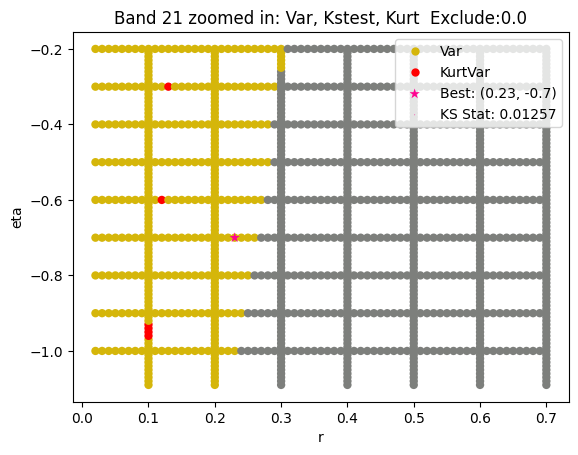

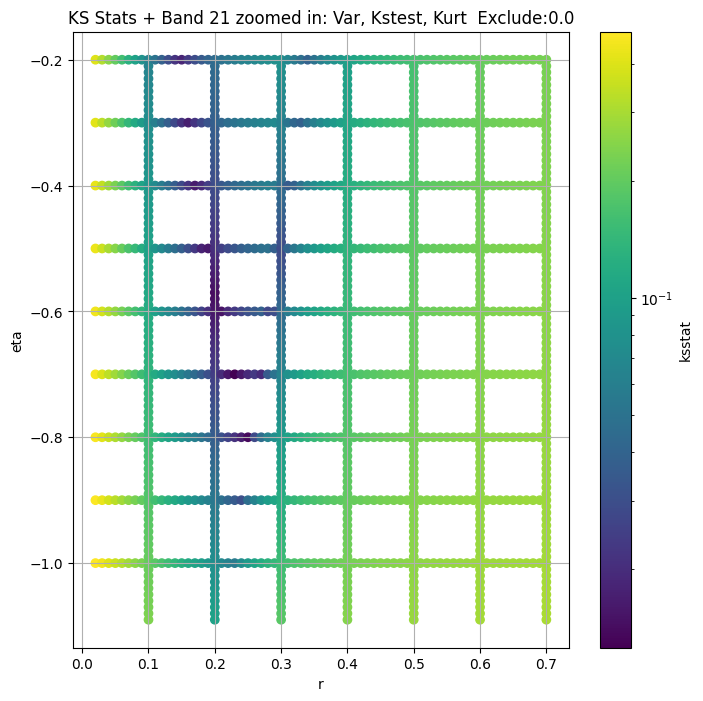

Band 24


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + 100 = 175, ksstat: 0.008356833195826772, var: 14645099.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + 75 = 150, ksstat: 0.008047939776699986, var: 15132227.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + 50 = 125, ksstat: 0.007592033414349109, var: 15660220.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + 25 = 100, ksstat: 0.007142034437838264, var: 16237624.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + 0 = 75, ksstat: 0.006659852643569792, var: 16877148.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + -25 = 50, ksstat: 0.006127421095320051, var: 17599260.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + -50 = 25, ksstat: 0.006205953168130718, var: 18444156.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 24, 75.0 + -75 = 0, ksstat: 0.005665811480550564, var: 19563218.0
Number of samples: 100000, Without approximation : 57390260.0


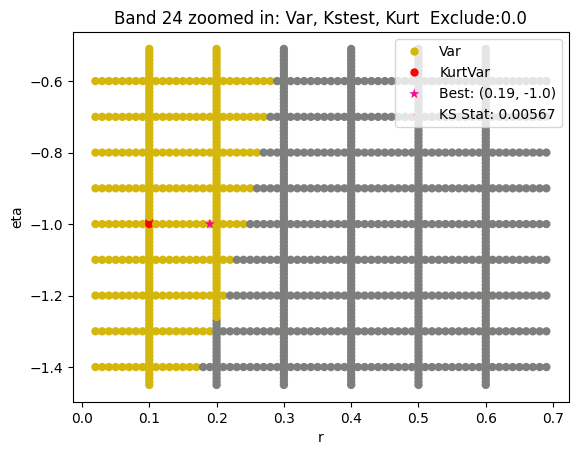

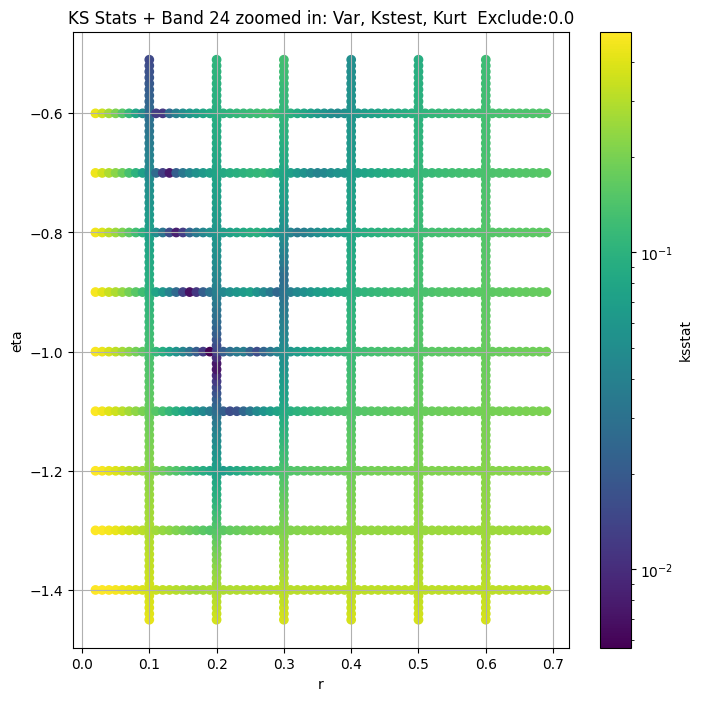

Band 27


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 100 = 450, ksstat: 0.012411955100426142, var: 2671803.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 75 = 425, ksstat: 0.012445929694616331, var: 2743140.75


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 50 = 400, ksstat: 0.012480584258568572, var: 2818073.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 25 = 375, ksstat: 0.012516000141822414, var: 2896944.75


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + 0 = 350, ksstat: 0.012272695168771441, var: 2980184.0


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -25 = 325, ksstat: 0.0123068428249547, var: 3068247.75


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -50 = 300, ksstat: 0.012345528884151247, var: 3161654.75


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -75 = 275, ksstat: 0.012385388325683144, var: 3261011.5


  0%|          | 0/1223 [00:00<?, ?it/s]

Finding Minimum after computing 1223 CDFs
band 27, 350.0 + -100 = 250, ksstat: 0.012426371786552703, var: 3366969.75
Number of samples: 100000, Without approximation : 57390260.0


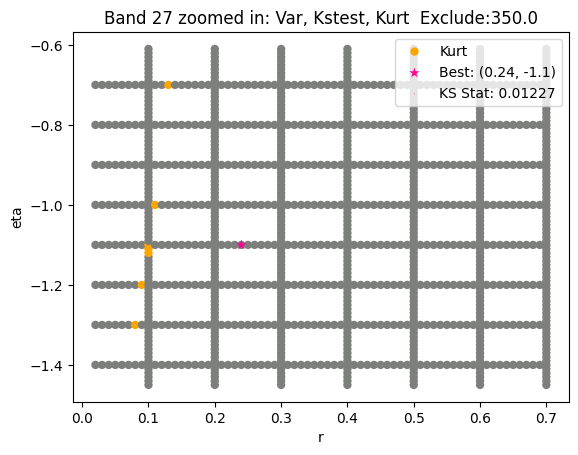

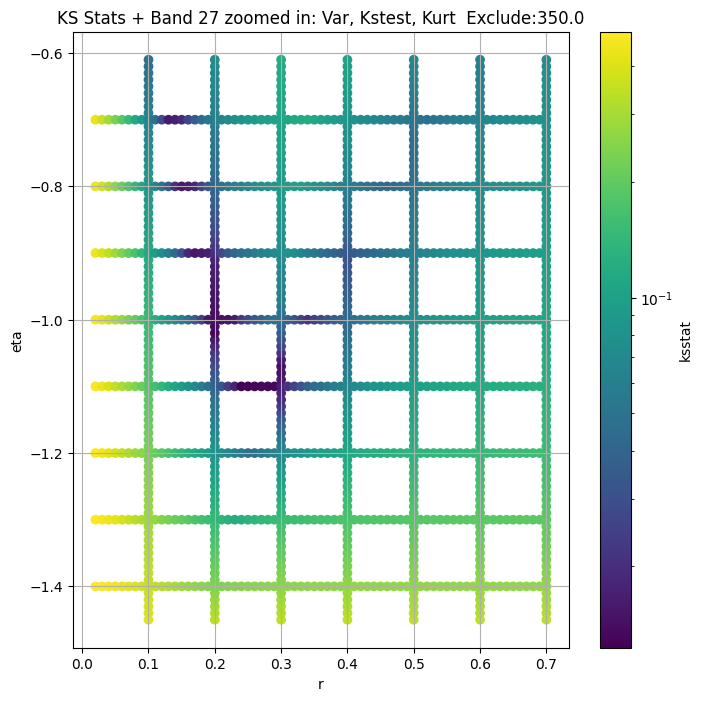

Band 31


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 100 = 450, ksstat: 0.03165501934566661, var: 66310.453125


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 75 = 425, ksstat: 0.03165501934566661, var: 68350.546875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 50 = 400, ksstat: 0.03165501934566661, var: 70520.640625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 25 = 375, ksstat: 0.03165501934566661, var: 72834.890625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + 0 = 350, ksstat: 0.03165501934566661, var: 75309.640625


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -25 = 325, ksstat: 0.03165501934566661, var: 77964.8984375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -50 = 300, ksstat: 0.03165501934566661, var: 80825.0546875


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -75 = 275, ksstat: 0.03165501934566661, var: 83918.5234375


  0%|          | 0/1022 [00:00<?, ?it/s]

Finding Minimum after computing 1022 CDFs
band 31, 350.0 + -100 = 250, ksstat: 0.03165501934566661, var: 87282.484375
Number of samples: 100000, Without approximation : 57390260.0


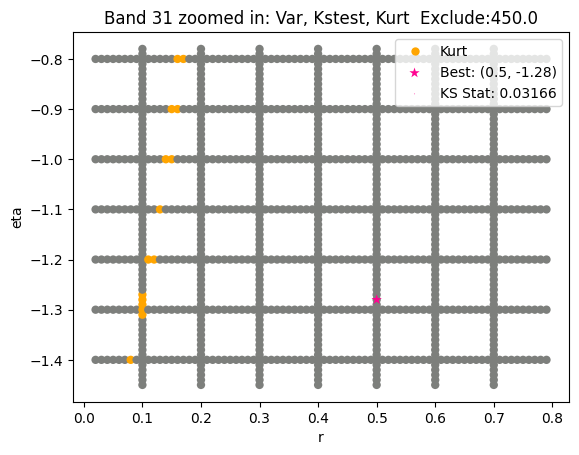

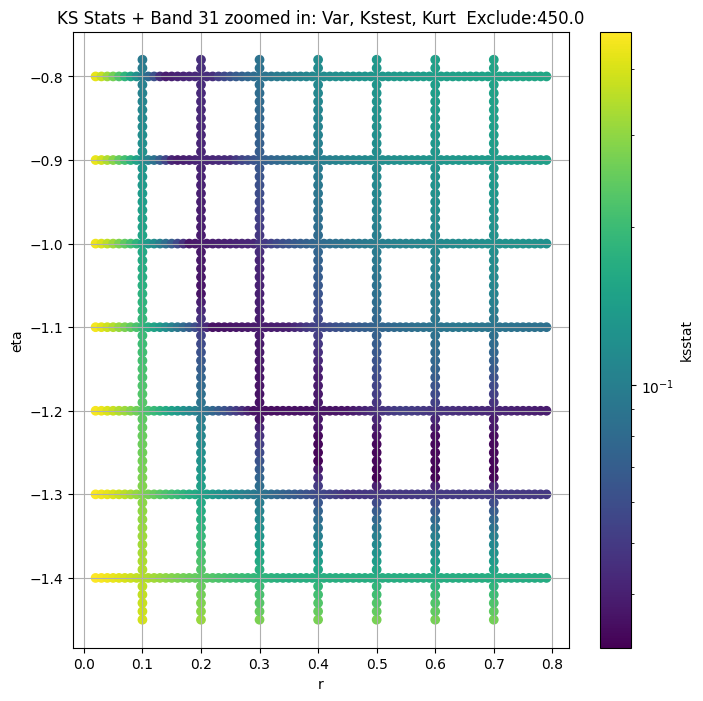

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.822466e+09  1.700348e+09  1.952399e+09    5.210897    4.492965   
5     2.076545e+09  1.956235e+09  2.200690e+09    3.248086    2.778626   
8     1.659445e+09  1.563706e+09  1.757885e+09    3.239433    2.819896   
11    1.339808e+09  1.261085e+09  1.419867e+09    3.335166    3.002649   
14    2.495633e+08  2.280835e+08  2.721146e+08    9.824538    8.402328   
18    6.059082e+07  5.541465e+07  6.623616e+07   10.046114    7.309242   
21    2.773545e+07  2.484259e+07  3.092608e+07   15.857981   11.606464   
24    1.956322e+07  1.685660e+07  2.253087e+07   29.648762   24.566576   
27    5.385740e+06  4.516624e+06  6.365170e+06   42.103700   31.579062   
31    1.729454e+05  1.348808e+05  2.302596e+05  106.234030   49.286438   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       6.073390     57390260.0             0.032459        0.2         -0.4   
5       3.767907     57390260.0             0.025654        0.2          0.6   
8       3.693572     57390260.0             0.023238        0.2          0.5   
11      3.688461     57390260.0             0.032265        0.2         -0.2   
14     11.439768     57390260.0             0.020031        0.2         -0.6   
18     14.069856     57390260.0             0.017852        0.2         -0.2   
21     22.578720     57390260.0             0.015940        0.2         -0.6   
24     35.480534     57390260.0             0.006660        0.2         -1.0   
27     57.521360     57390260.0             0.013894        0.2         -1.0   
31    312.297030     57390260.0             0.035690        0.3         -1.2   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      82612.950489                    25.0        1.822466e+09   
5       7028.173634                     0.0        2.076545e+09   
8       6907.445088                     0.0        1.659445e+09   
11     32414.257290                     0.0        1.339808e+09   
14     24333.910593                     0.0        2.495633e+08   
18      1410.290420                    25.0        6.059082e+07   
21      2704.372619                     0.0        2.773545e+07   
24     11989.537929                    75.0        1.956322e+07   
27      2117.124831                   350.0        2.980184e+06   
31      8132.326628                   350.0        6.631045e+04   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.000179          0.032064    0.20     -0.41   
5                    0.000179          0.025301    0.22      0.40   
8                    0.000179          0.022797    0.22      0.30   
11                   0.000179          0.031470    0.20     -0.17   
14                   0.000179          0.018979    0.20     -0.58   
18                   0.000179          0.015560    0.25     -0.50   
21                   0.000179          0.012566    0.23     -0.70   
24                   0.000179          0.005666    0.19     -1.00   
27                   0.000179          0.012273    0.24     -1.10   
31                   0.000179          0.031655    0.50     -1.28   

         best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                   
2      87148.185200                  0.0         1751  
5      51033.625737                  0.0         2953  
8      50124.806379                  0.0         3502  
11     29625.549612                  0.0         1867  
14     22458.400344                  0.0         5253  
18     72131.923810                  0.0         7879  
21     25302.238135                  0.0        11820  
24      7021.929899    

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

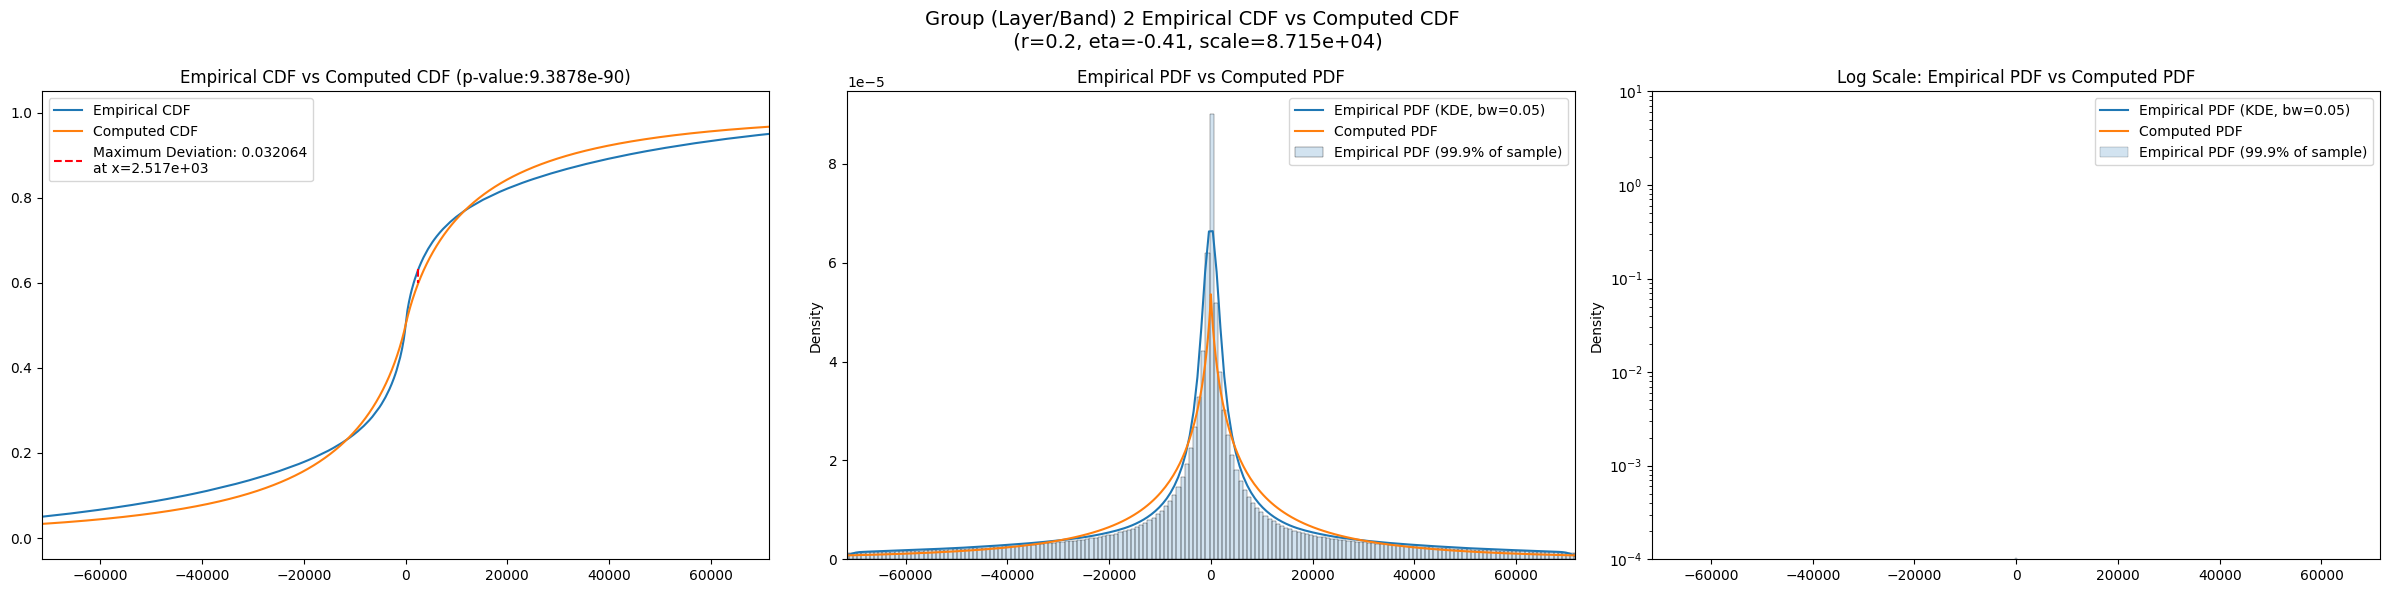

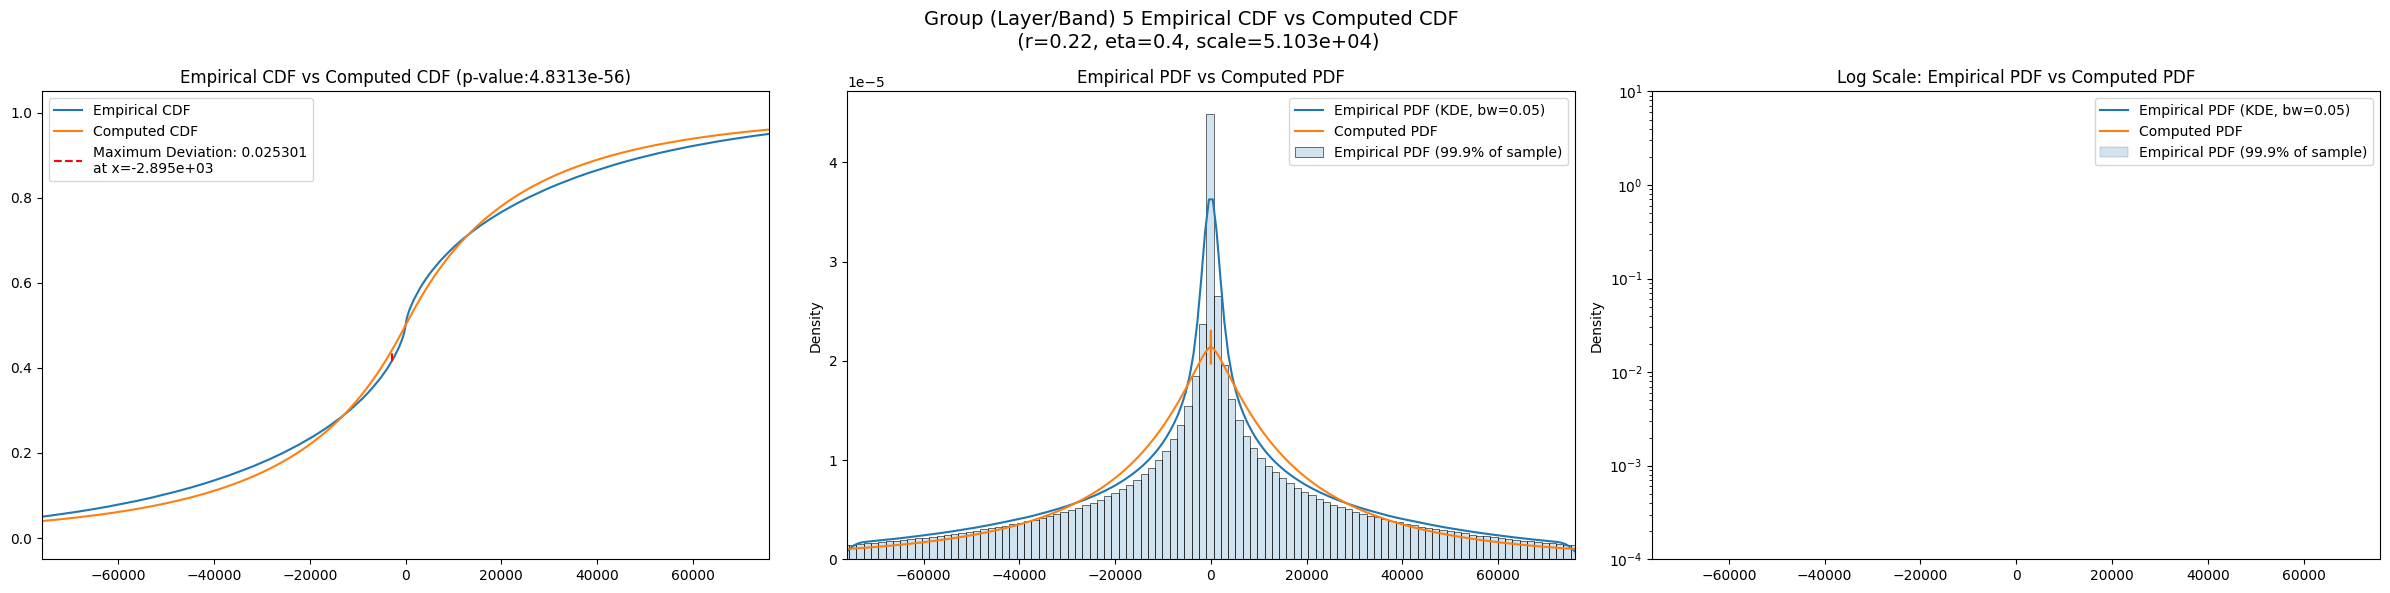

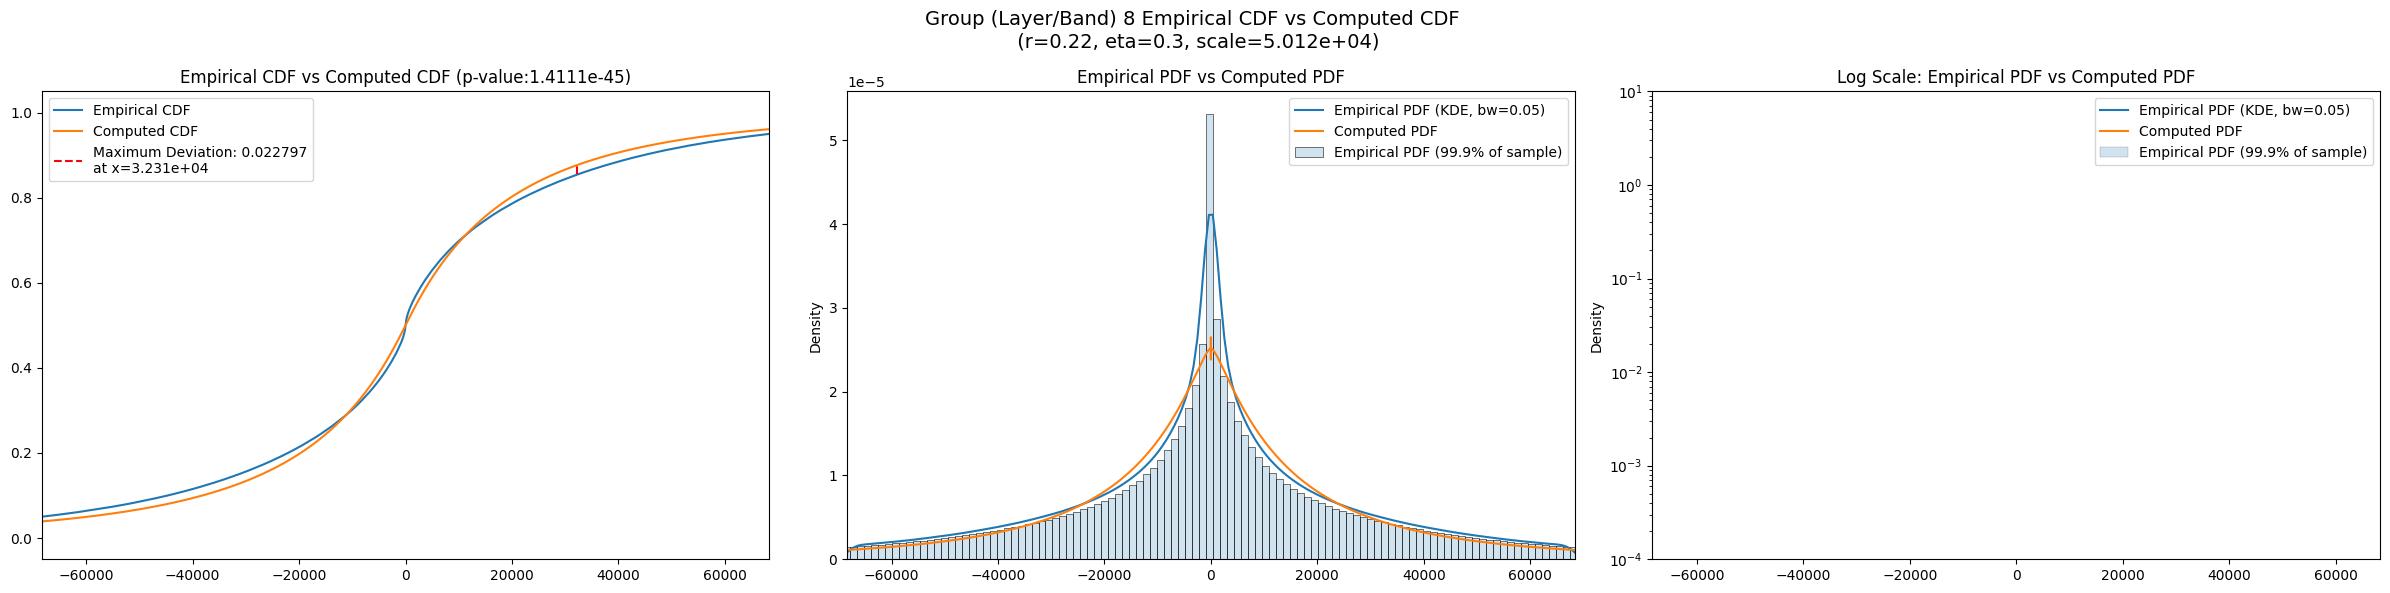

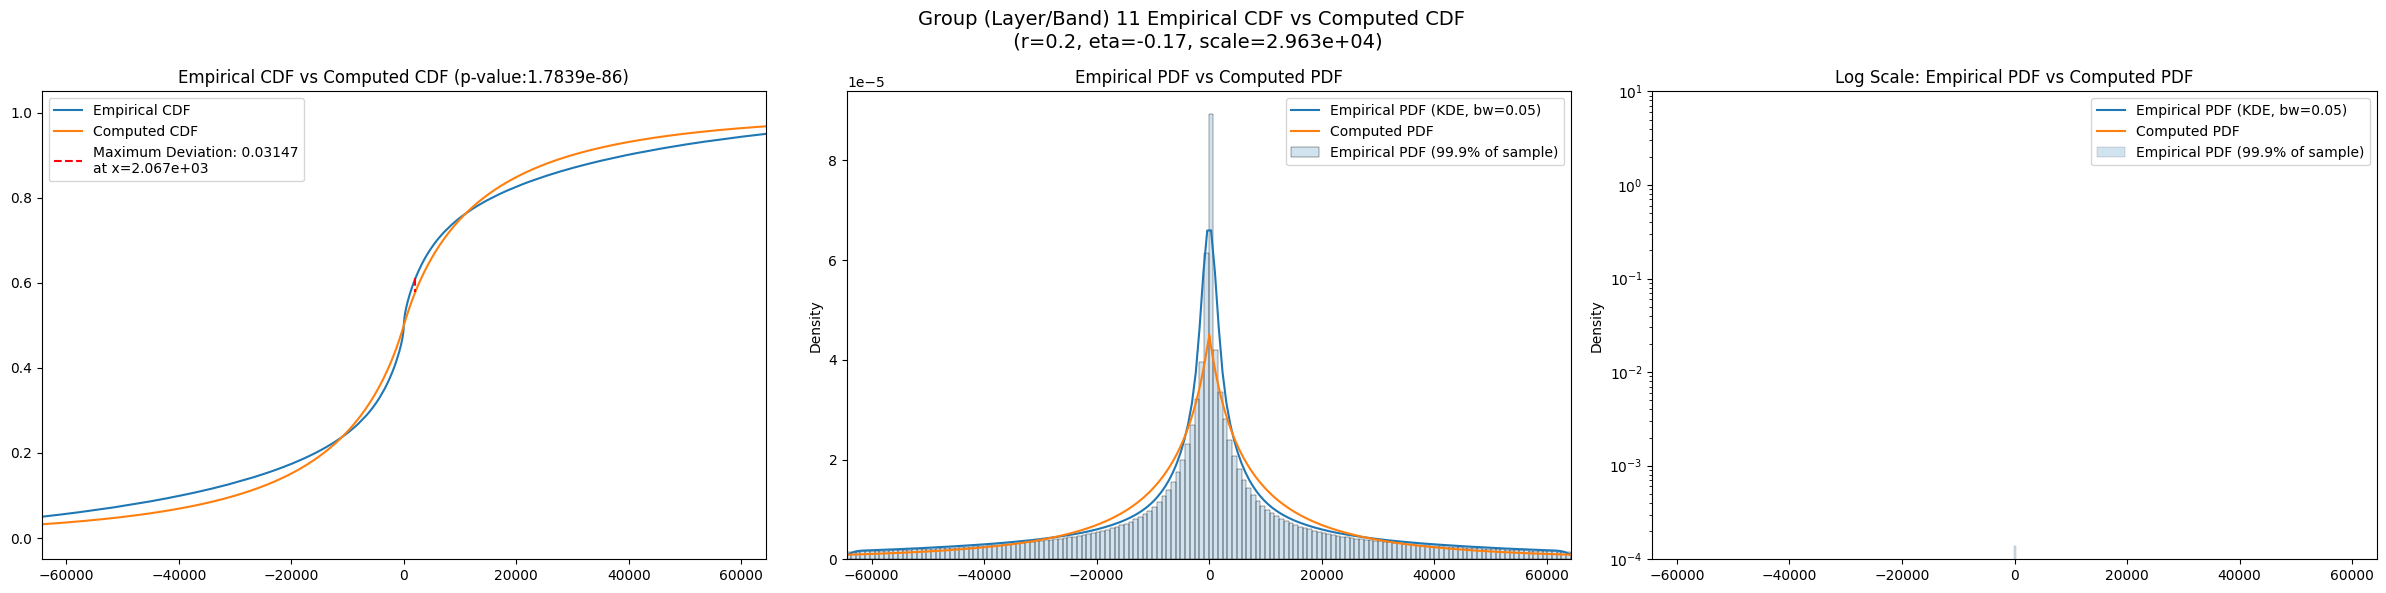

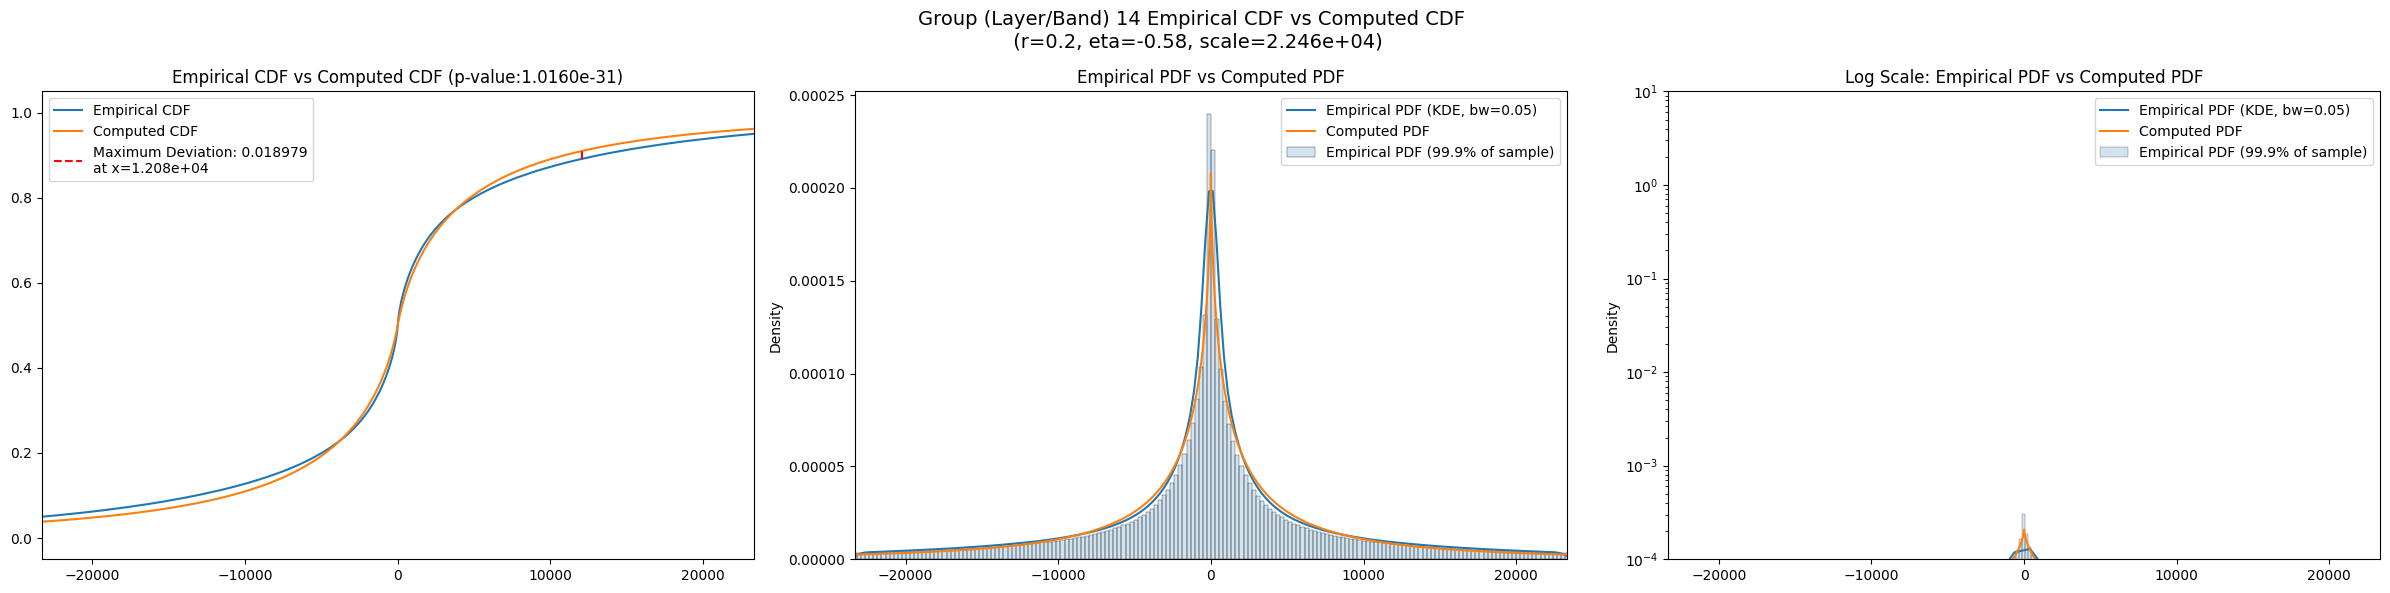

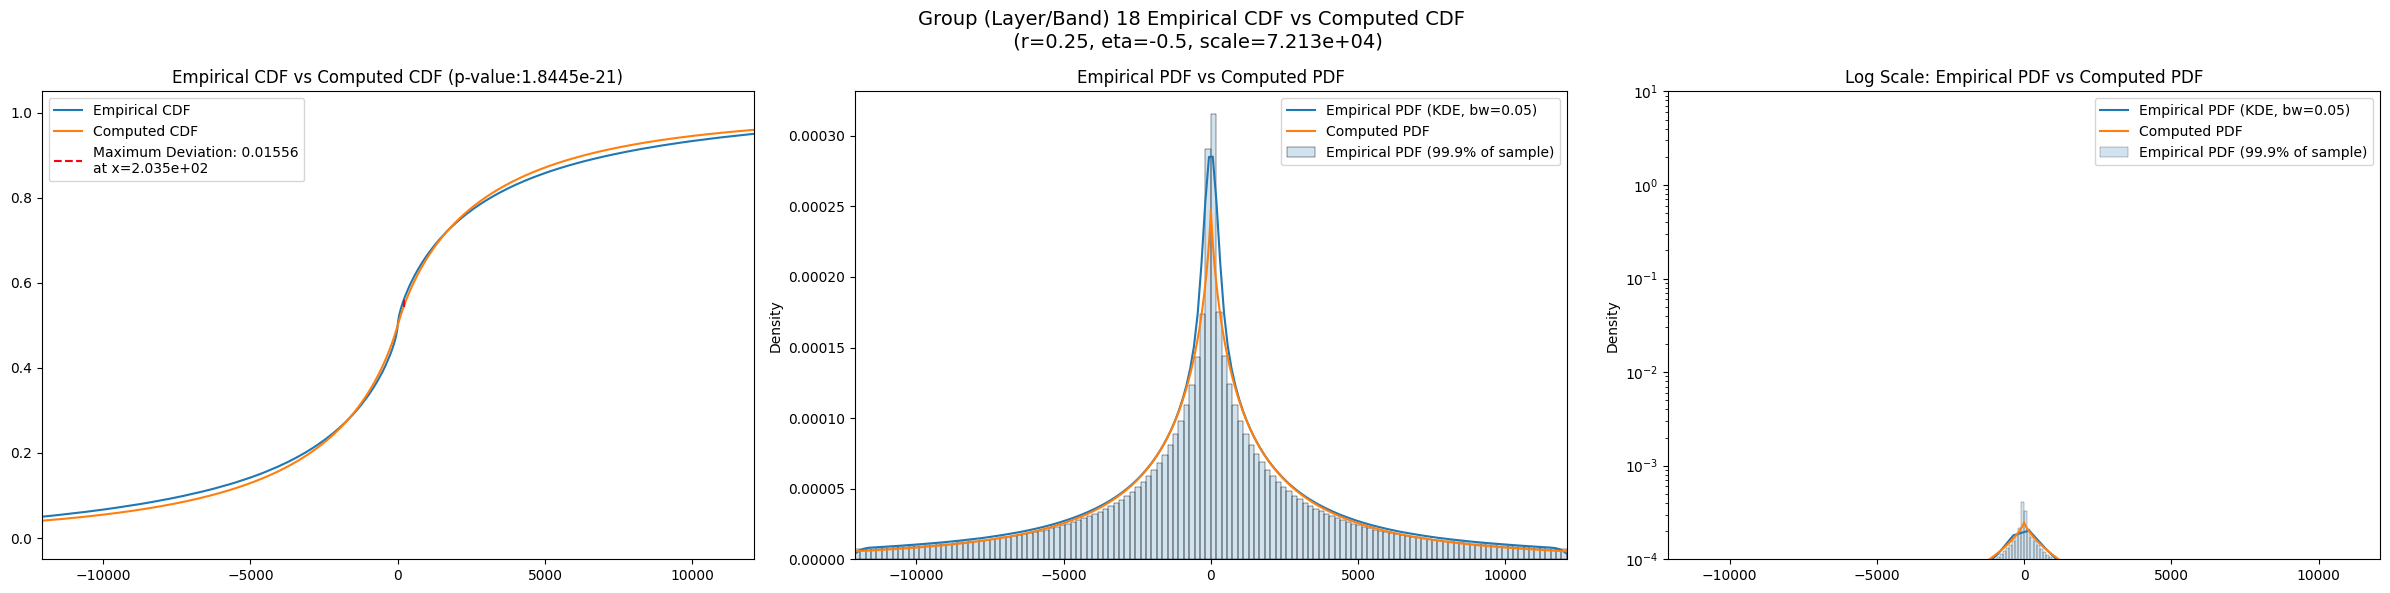

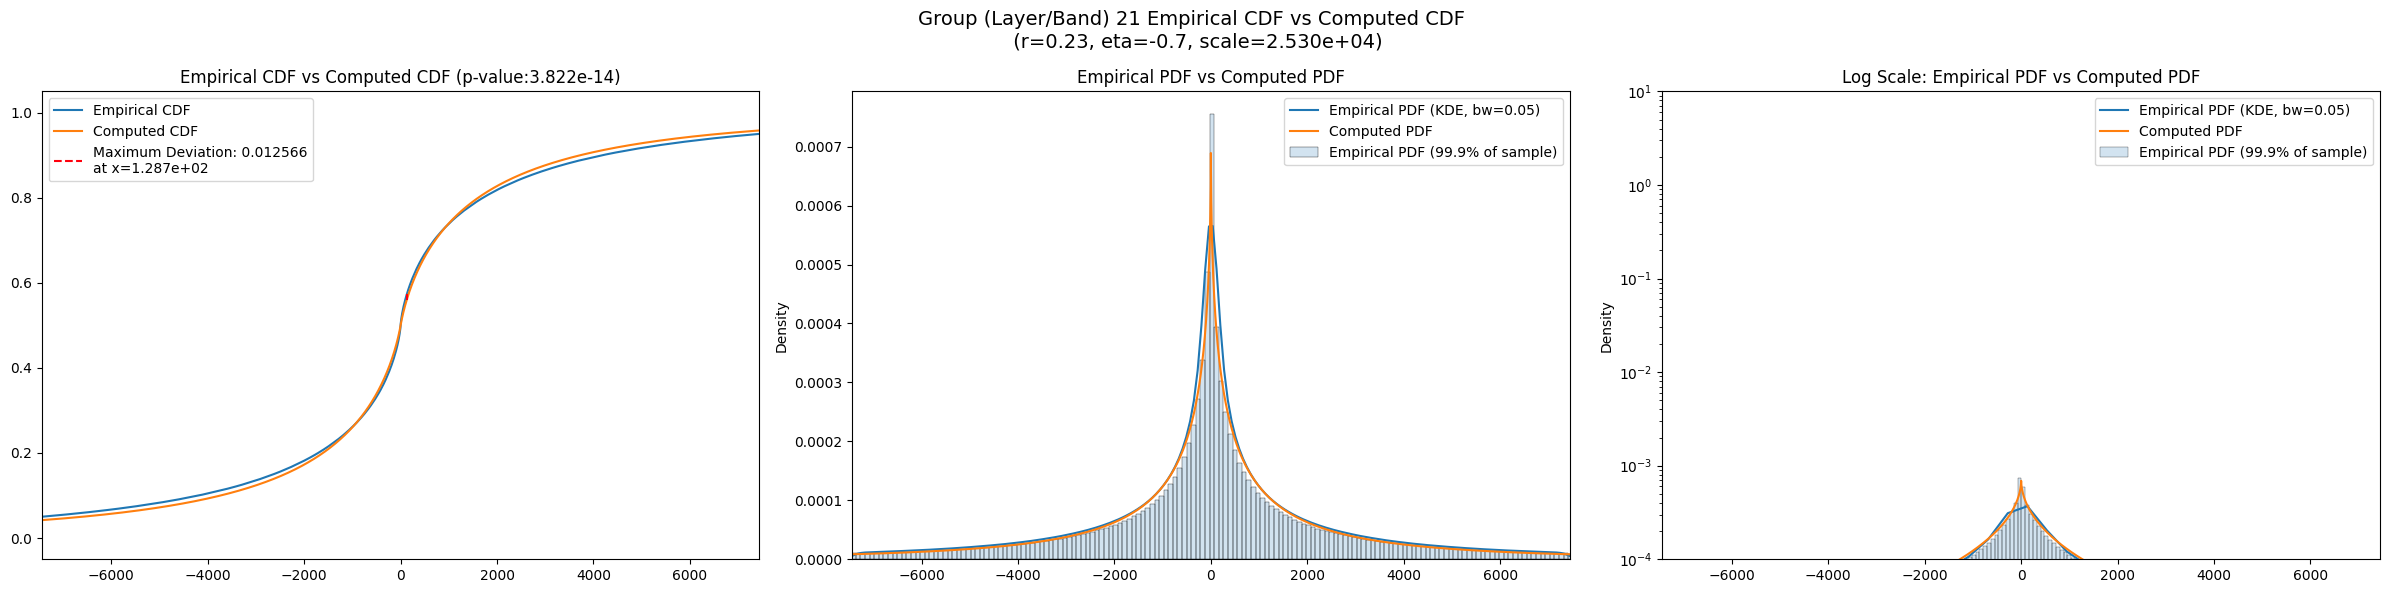

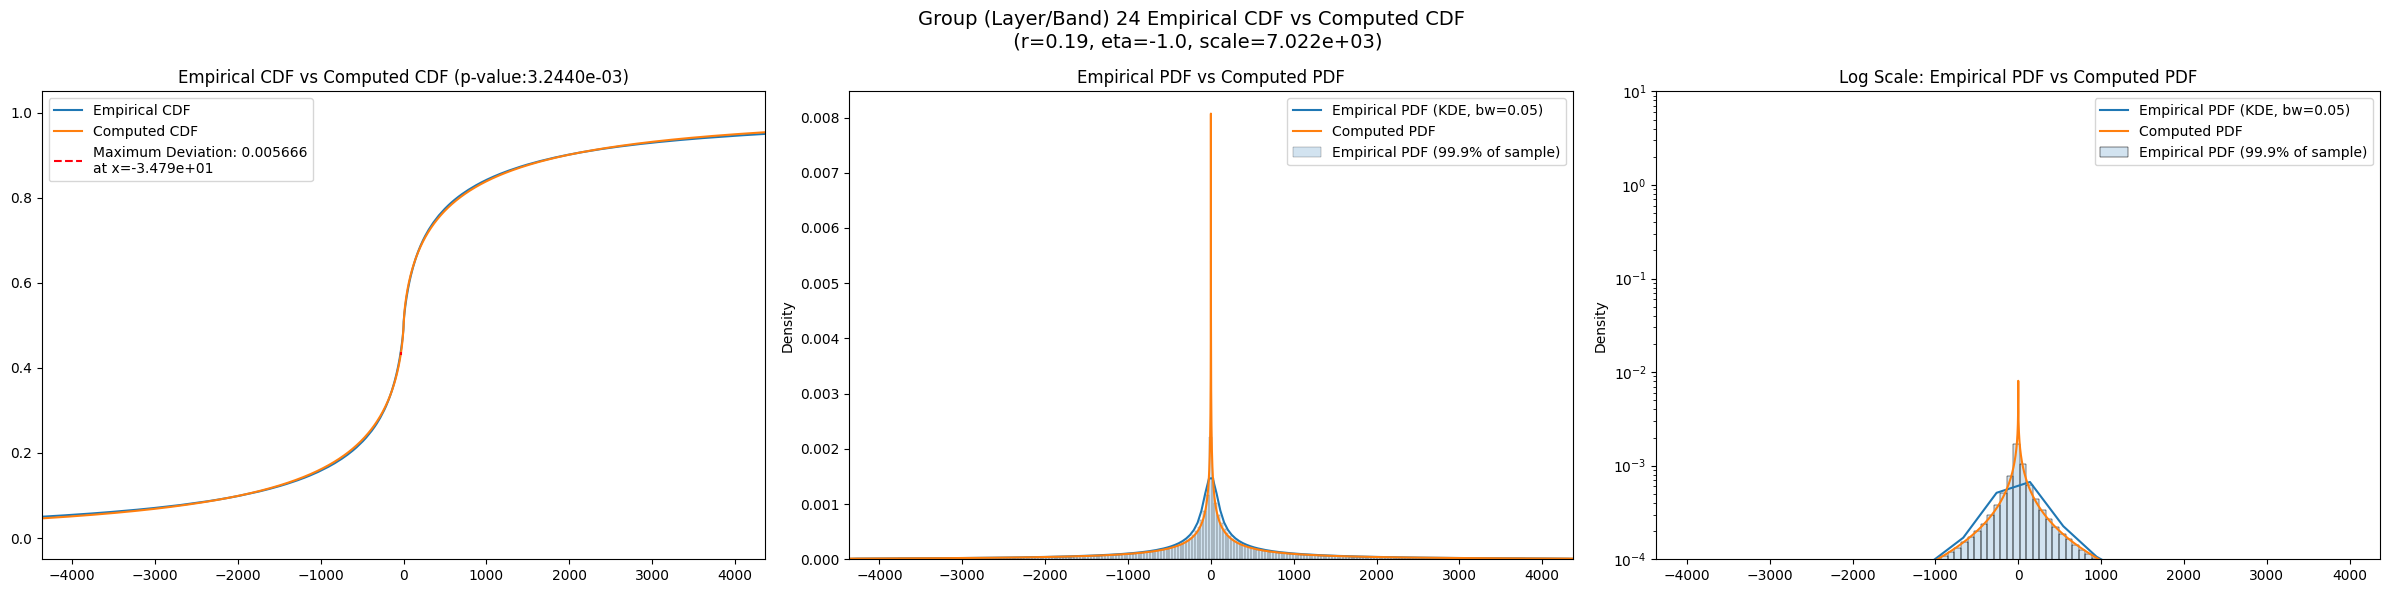

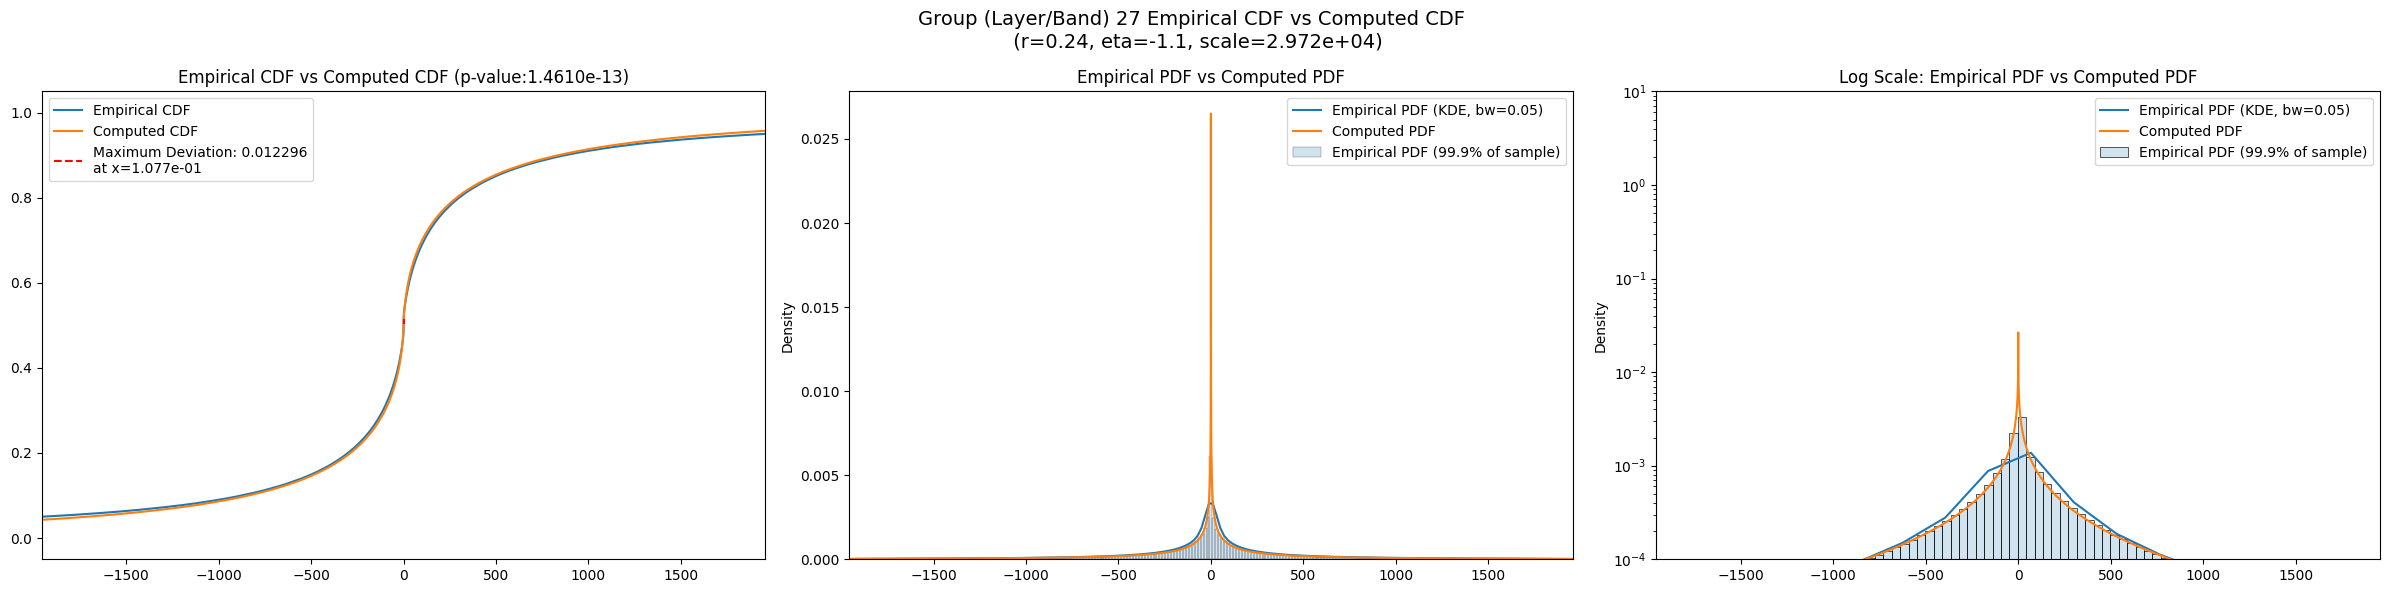

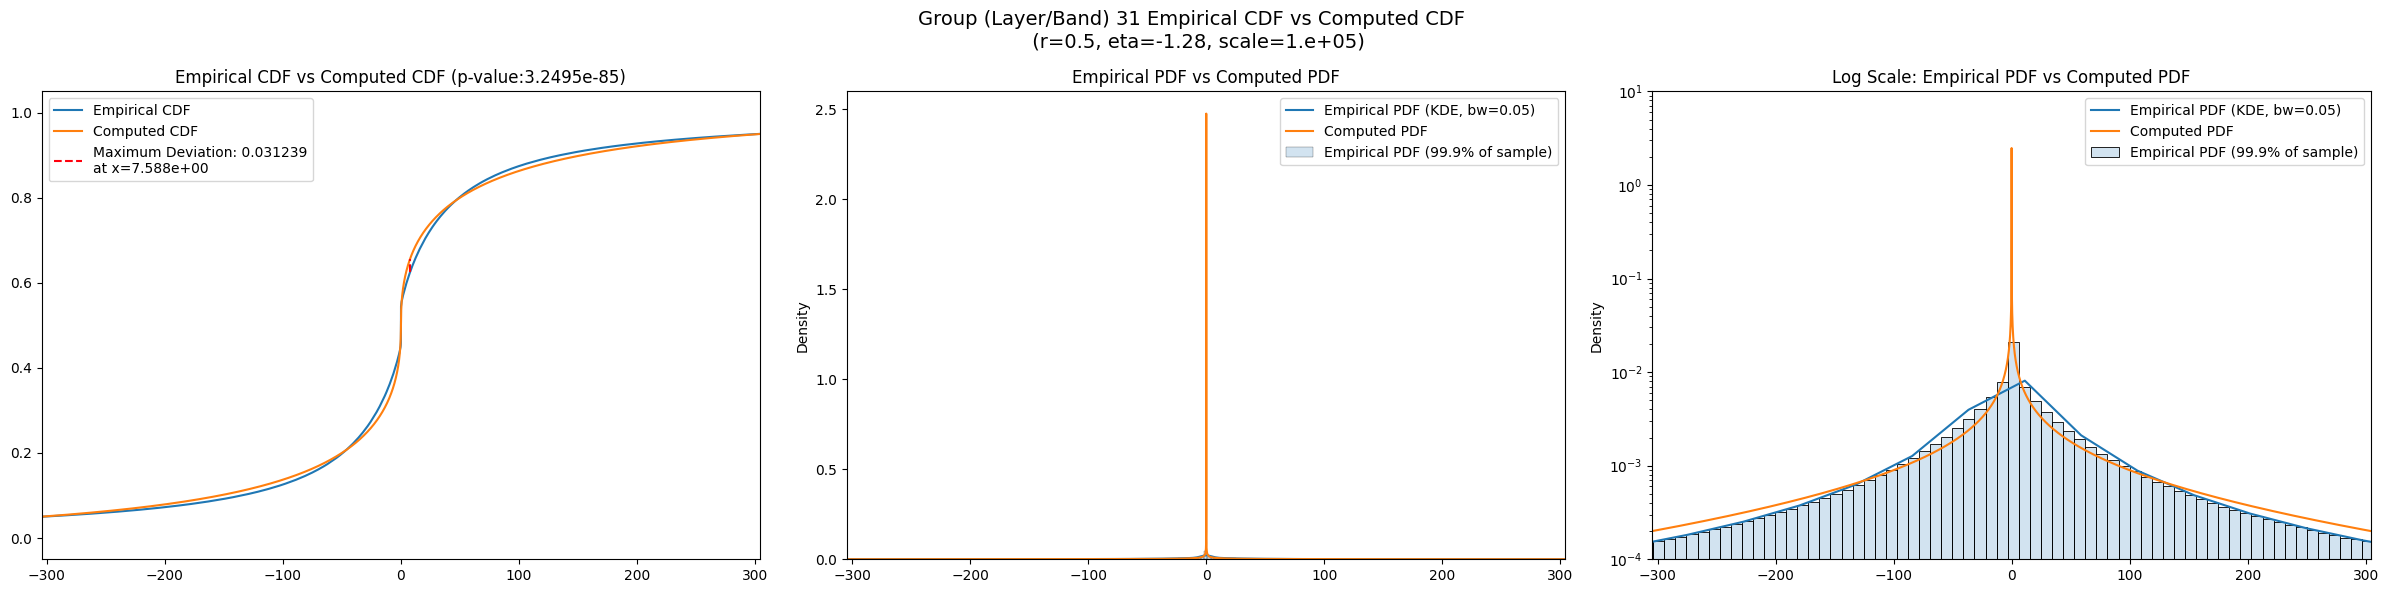

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.822466e+09  1.700348e+09  1.952399e+09    5.210897    4.492965   
5     2.076545e+09  1.956235e+09  2.200690e+09    3.248086    2.778626   
8     1.659445e+09  1.563706e+09  1.757885e+09    3.239433    2.819896   
11    1.339808e+09  1.261085e+09  1.419867e+09    3.335166    3.002649   
14    2.495633e+08  2.280835e+08  2.721146e+08    9.824538    8.402328   
18    6.059082e+07  5.541465e+07  6.623616e+07   10.046114    7.309242   
21    2.773545e+07  2.484259e+07  3.092608e+07   15.857981   11.606464   
24    1.956322e+07  1.685660e+07  2.253087e+07   29.648762   24.566576   
27    5.385740e+06  4.516624e+06  6.365170e+06   42.103700   31.579062   
31    1.729454e+05  1.348808e+05  2.302596e+05  106.234030   49.286438   

      kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                           
2       6.073390     57390260.0             0.032459        0.2         -0.4   
5       3.767907     57390260.0             0.025654        0.2          0.6   
8       3.693572     57390260.0             0.023238        0.2          0.5   
11      3.688461     57390260.0             0.032265        0.2         -0.2   
14     11.439768     57390260.0             0.020031        0.2         -0.6   
18     14.069856     57390260.0             0.017852        0.2         -0.2   
21     22.578720     57390260.0             0.015940        0.2         -0.6   
24     35.480534     57390260.0             0.006660        0.2         -1.0   
27     57.521360     57390260.0             0.013894        0.2         -1.0   
31    312.297030     57390260.0             0.035690        0.3         -1.2   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...      19411.9000              0.089042                   0.0   
5     ...      30134.8000              0.056342                   0.0   
8     ...      26535.1000              0.056066                   0.0   
11    ...      19170.9000              0.081116                   0.0   
14    ...       6291.3000              0.082481                   0.0   
18    ...       4009.8200              0.066379                   0.0   
21    ...       2140.6800              0.075687                   0.0   
24    ...        843.7690              0.090887                   0.0   
27    ...        387.6640              0.088595                   0.0   
31    ...         64.7808              0.082319                   0.0   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
band                                                                        
2        16620.6000             0.063635                  0.0  13017.0000   
5        25637.2000             0.032370                  0.0  20920.3000   
8        22623.9000             0.031145                  0.0  18349.3000   
11       16434.8000             0.055459                  0.0  12933.7000   
14        5415.4000             0.057053                  0.0   4208.5600   
18        3448.3800             0.040675                  0.0   2704.4900   
21        1837.9600             0.050544                  0.0   1429.8800   
24         736.1230             0.066761                  0.0    557.2470   
27         335.9770             0.064853                  0.0    253.6400   
31          55.6998             0.059904                  0.0     41.3403   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.065351            0.0                   0.0  
5          0.037643            0.0                   0.0  
8          0.036004            0.0                   0.0  
11         0.057604            0.0                   0.0  
14   

## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.032459                 0.000179          0.032064   
5                0.025654                 0.000179          0.025301   
8                0.023238                 0.000179          0.022797   
11               0.032265                 0.000179          0.031470   
14               0.020031                 0.000179          0.018979   
18               0.017852                 0.000179          0.015560   
21               0.015940                 0.000179          0.012566   
24               0.006660                 0.000179          0.005666   
27               0.013894                 0.000179          0.012273   
31               0.035690                 0.000179          0.031655   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.089042             0.063635       0.065351  
5                 0.056342             0.032370       0.037643  
8                 0.056066             0.031145       0.036004  
11                0.081116             0.055459       0.057604  
14                0.082481             0.057053       0.058111  
18                0.066379             0.040675       0.042771  
21                0.075687             0.050544       0.051947  
24                0.090887             0.066761       0.065472  
27                0.088595             0.064853       0.064069  
31                0.082319             0.059904       0.059522

In [21]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta     best_scale  \
band                                                                          
2           1.822466e+09          0.032064    0.20     -0.41   87148.185200   
5           2.076545e+09          0.025301    0.22      0.40   51033.625737   
8           1.659445e+09          0.022797    0.22      0.30   50124.806379   
11          1.339808e+09          0.031470    0.20     -0.17   29625.549612   
14          2.495633e+08          0.018979    0.20     -0.58   22458.400344   
18          6.059082e+07          0.015560    0.25     -0.50   72131.923810   
21          2.773545e+07          0.012566    0.23     -0.70   25302.238135   
24          1.956322e+07          0.005666    0.19     -1.00    7021.929899   
27          2.980184e+06          0.012273    0.24     -1.10   29717.694095   
31          6.631045e+04          0.031655    0.50     -1.28  100000.000000   

      best_exclude_cutoff  
band                       
2                     0.0  
5                     0.0  
8                     0.0  
11                    0.0  
14                    0.0  
18                    0.0  
21                    0.0  
24                    0.0  
27                  350.0  
31                  450.0